In [ ]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Install and import XGBoost
!pip install xgboost
import xgboost as xgb

# Import TensorFlow/Keras for deep learning
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load the Data
file_path = '/content/drive/MyDrive/bq-results-20241115-074536-1731656781107/ANNG.csv'
data = pd.read_csv(file_path)

# Ensure the dates are in datetime format
data['SQLDATE'] = pd.to_datetime(data['SQLDATE'])

# Step 2: Filter and Sort the Data
data = data[data['Actor1Name'].isin(['GOOGLE', 'NETFLIX', 'NVIDIA', 'APPLE'])]
# Sort by date and company
data = data.sort_values(by=['SQLDATE', 'Actor1Name']).reset_index(drop=True)

# Step 3: Feature Engineering
# Lag features
data['Lag_1'] = data.groupby('Actor1Name')['AvgTone'].shift(1)
data['Lag_2'] = data.groupby('Actor1Name')['AvgTone'].shift(2)
data['Rolling_Mean'] = data.groupby('Actor1Name')['AvgTone'].rolling(3).mean().reset_index(0, drop=True)
data = data.dropna()

# Step 4: Train-Test Split
X = data[['Lag_1', 'Lag_2', 'Rolling_Mean']]
y = data['AvgTone']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Find the last date in the dataset
last_date = data['SQLDATE'].max()
print(f"The last date in the dataset is: {last_date}")

The last date in the dataset is: 2024-11-15 00:00:00


In [ ]:
# ---------- PART 1: XGBOOST MODEL ----------
# Convert data to DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters for XGBoost
params = {
    'objective': 'reg:squarederror',
    'max_depth': 6,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # Updated to 'hist'
    'device': 'cuda'       # Use CUDA for GPU acceleration
}

# Train with early stopping
xgb_model = xgb.train(params, dtrain, num_boost_round=500, early_stopping_rounds=20, evals=[(dtest, 'test')])

# Predictions and Evaluation
y_pred_xgb = xgb_model.predict(dtest)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.4f}")

# Save Predictions
output_xgb = pd.DataFrame({'Actual': y_test, 'Predicted_XGBoost': y_pred_xgb})
output_xgb.to_csv('/content/drive/MyDrive/xgb_forecast_results.csv', index=False)


[0]	test-rmse:3.01423
[1]	test-rmse:3.01344
[2]	test-rmse:3.01274
[3]	test-rmse:2.88117
[4]	test-rmse:2.74738
[5]	test-rmse:2.64040
[6]	test-rmse:2.53007
[7]	test-rmse:2.44212
[8]	test-rmse:2.36722
[9]	test-rmse:2.30380
[10]	test-rmse:2.25063
[11]	test-rmse:2.15677
[12]	test-rmse:2.14250
[13]	test-rmse:2.06273
[14]	test-rmse:2.05079
[15]	test-rmse:1.99743
[16]	test-rmse:1.92726
[17]	test-rmse:1.91453
[18]	test-rmse:1.86551
[19]	test-rmse:1.85266
[20]	test-rmse:1.84202
[21]	test-rmse:1.79528
[22]	test-rmse:1.75611
[23]	test-rmse:1.74204
[24]	test-rmse:1.70608
[25]	test-rmse:1.67587
[26]	test-rmse:1.65054
[27]	test-rmse:1.57983
[28]	test-rmse:1.56116
[29]	test-rmse:1.54583
[30]	test-rmse:1.51754
[31]	test-rmse:1.50226
[32]	test-rmse:1.48974
[33]	test-rmse:1.43275
[34]	test-rmse:1.42288
[35]	test-rmse:1.41482
[36]	test-rmse:1.36592
[37]	test-rmse:1.33089
[38]	test-rmse:1.30167
[39]	test-rmse:1.27684
[40]	test-rmse:1.23106
[41]	test-rmse:1.19183
[42]	test-rmse:1.15847
[43]	test-rmse:1.1302

In [ ]:
# ---------- PART 2: LSTM MODEL ----------
# Scale data for LSTM
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM input
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Build the LSTM model
model_lstm = Sequential([
    LSTM(64, activation='relu', input_shape=(1, X_train_lstm.shape[2])),
    Dense(1)  # Output layer
])
model_lstm.compile(optimizer='adam', loss='mae')

# Train the LSTM model
model_lstm.fit(X_train_lstm, y_train, epochs=20, batch_size=32, verbose=1)

# Predict and evaluate
y_pred_lstm = model_lstm.predict(X_test_lstm).flatten()
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
print(f"LSTM MAE: {mae_lstm:.4f}")

# Save LSTM predictions
output_lstm = pd.DataFrame({'Actual': y_test, 'Predicted_LSTM': y_pred_lstm})
output_lstm.to_csv('/content/drive/MyDrive/lstm_forecast_results.csv', index=False)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step - loss: 0.8777
Epoch 2/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0183
Epoch 3/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0168
Epoch 4/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0171
Epoch 5/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0172
Epoch 6/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - loss: 0.0186
Epoch 7/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0178
Epoch 8/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0175
Epoch 9/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0174
Epoch 10/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0174
Epoch 11/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 31s 1ms/step - loss: 0.0179
Epoch 12/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0181
Epoch 13/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - loss: 0.0180
Epoch 14/20
28716/28716 ━━━━━━━━━━━━━━━━━━━━ 32s 1ms/step - 

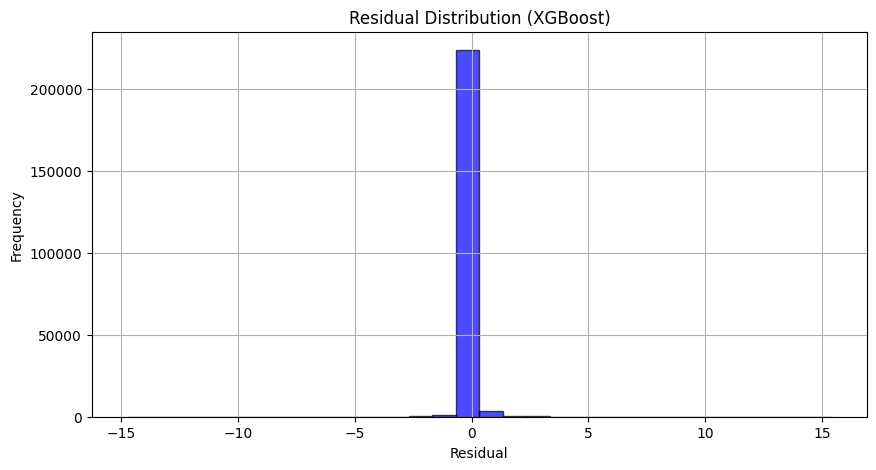

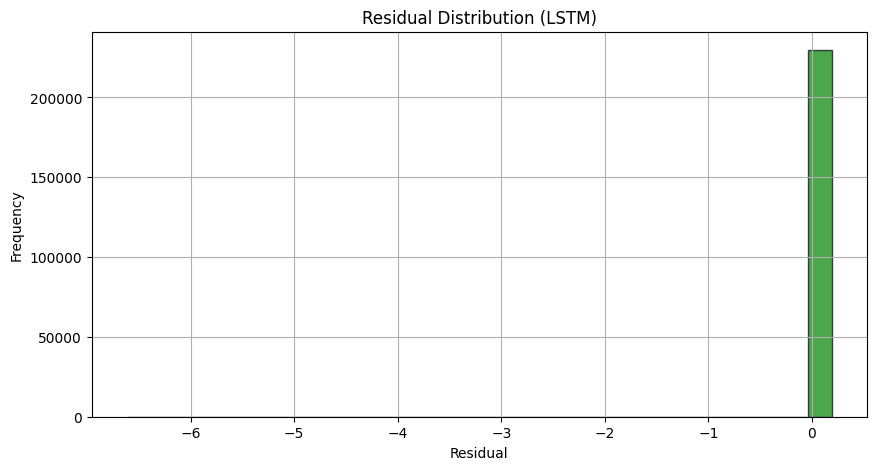

In [ ]:
# Residual Analysis for XGBoost
residuals_xgb = y_test.values - y_pred_xgb
plt.figure(figsize=(10, 5))
plt.hist(residuals_xgb, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title('Residual Distribution (XGBoost)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Residual Analysis for LSTM
residuals_lstm = y_test.values - y_pred_lstm
plt.figure(figsize=(10, 5))
plt.hist(residuals_lstm, bins=30, color='green', alpha=0.7, edgecolor='black')
plt.title('Residual Distribution (LSTM)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.grid()
plt.show()


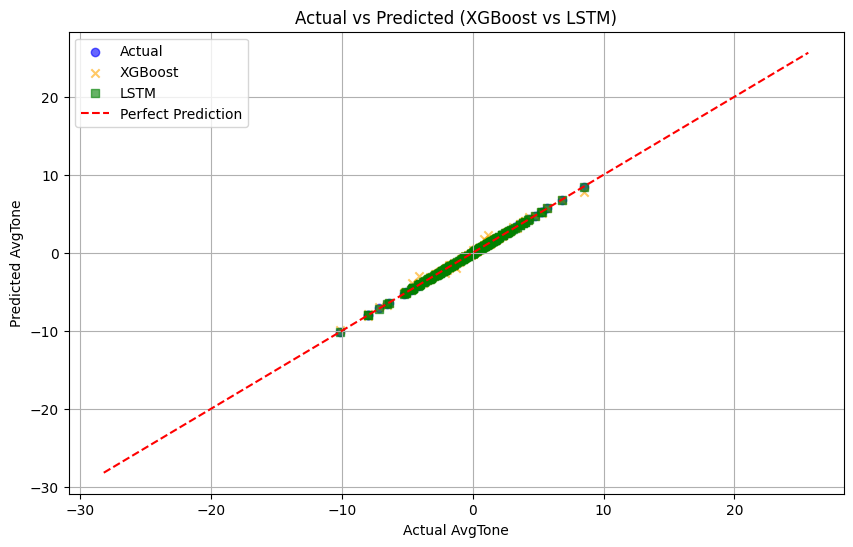

In [ ]:
plt.figure(figsize=(10, 6))
subset = 200  # Visualize a subset of data for clarity

# Plot actual values against themselves
plt.scatter(y_test.values[:subset], y_test.values[:subset], label='Actual', alpha=0.6, color='blue', marker='o')

# XGBoost predictions
plt.scatter(y_test.values[:subset], y_pred_xgb[:subset], label='XGBoost', alpha=0.6, color='orange', marker='x')

# LSTM predictions
plt.scatter(y_test.values[:subset], y_pred_lstm[:subset], label='LSTM', alpha=0.6, color='green', marker='s')

# Perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')

# Labels and legend
plt.title('Actual vs Predicted (XGBoost vs LSTM)')
plt.xlabel('Actual AvgTone')
plt.ylabel('Predicted AvgTone')
plt.legend()
plt.grid()
plt.show()


Combined Model MAE: 0.0490


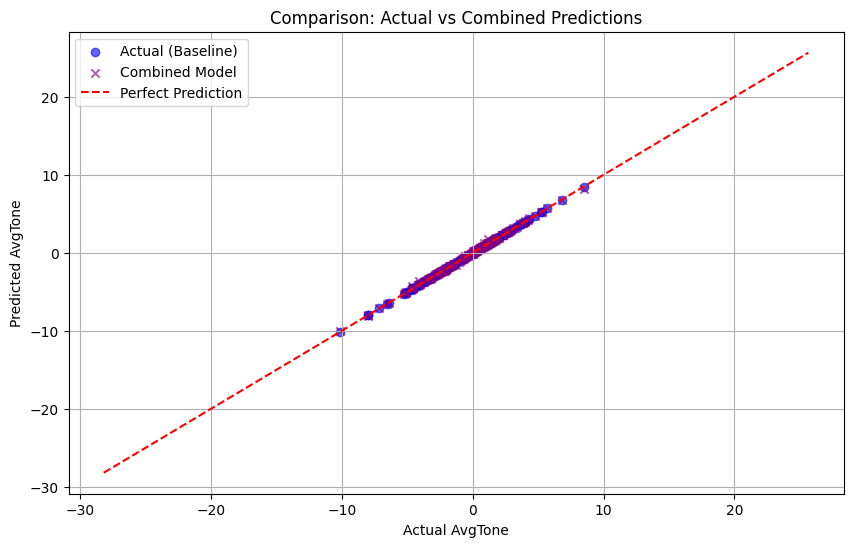

In [ ]:
# Combine Predictions from XGBoost and LSTM
combined_pred = (y_pred_xgb + y_pred_lstm) / 2

# Evaluate Combined Model
mae_combined = mean_absolute_error(y_test, combined_pred)
print(f"Combined Model MAE: {mae_combined:.4f}")

# Scatter Plot for Combined Predictions
plt.figure(figsize=(10, 6))
subset = 200  # Visualize a subset of data for clarity

# Actual values baseline (y_test vs. y_test)
plt.scatter(y_test.values[:subset], y_test.values[:subset], label='Actual (Baseline)', alpha=0.6, color='blue', marker='o')

# Combined predictions (average of XGBoost and LSTM)
plt.scatter(y_test.values[:subset], combined_pred[:subset], label='Combined Model', alpha=0.6, color='purple', marker='x')

# Perfect prediction line
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', label='Perfect Prediction')

# Plot settings
plt.title('Comparison: Actual vs Combined Predictions')
plt.xlabel('Actual AvgTone')
plt.ylabel('Predicted AvgTone')
plt.legend()
plt.grid()
plt.show()


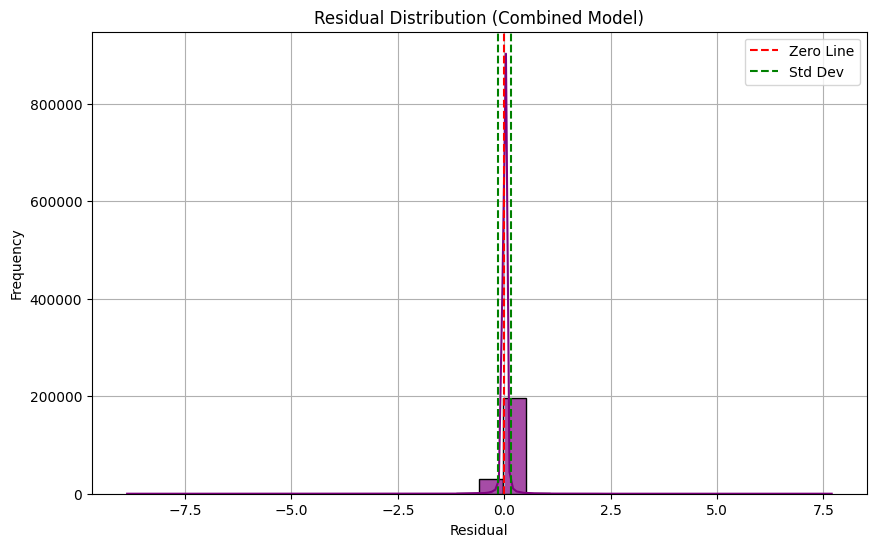

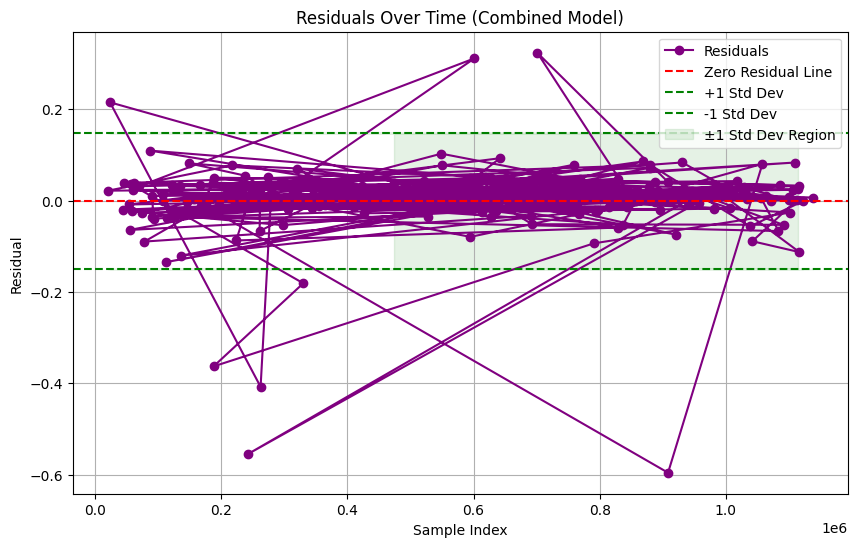

Residual Summary Statistics:
Mean Residual: 0.0101
Standard Deviation of Residuals: 0.1490
Median Residual: 0.0104
Min Residual: -8.8621
Max Residual: 7.6944


In [ ]:
# Residuals for Combined Model
residuals_combined = y_test.values - combined_pred

# Plot Residual Distribution
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(residuals_combined, bins=30, kde=True, color='purple', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', label='Zero Line')
plt.axvline(residuals_combined.std(), color='g', linestyle='--', label='Std Dev')
plt.axvline(-residuals_combined.std(), color='g', linestyle='--')
plt.title('Residual Distribution (Combined Model)')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

# Residuals Over Time

std_res = residuals_combined.std()
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[:subset], residuals_combined[:subset], label='Residuals', color='purple', marker='o')
plt.axhline(y=0, color='r', linestyle='--', label='Zero Residual Line')
plt.axhline(y=std_res, color='g', linestyle='--', label='+1 Std Dev')
plt.axhline(y=-std_res, color='g', linestyle='--', label='-1 Std Dev')
plt.fill_between(y_test.index[:subset], -std_res, std_res, color='green', alpha=0.1, label='±1 Std Dev Region')
plt.title('Residuals Over Time (Combined Model)')
plt.xlabel('Sample Index')
plt.ylabel('Residual')
plt.legend()
plt.grid()
plt.show()

print("Residual Summary Statistics:")
print(f"Mean Residual: {residuals_combined.mean():.4f}")
print(f"Standard Deviation of Residuals: {residuals_combined.std():.4f}")
print(f"Median Residual: {np.median(residuals_combined):.4f}")
print(f"Min Residual: {residuals_combined.min():.4f}")
print(f"Max Residual: {residuals_combined.max():.4f}")


Combined Model MAE: 0.0576


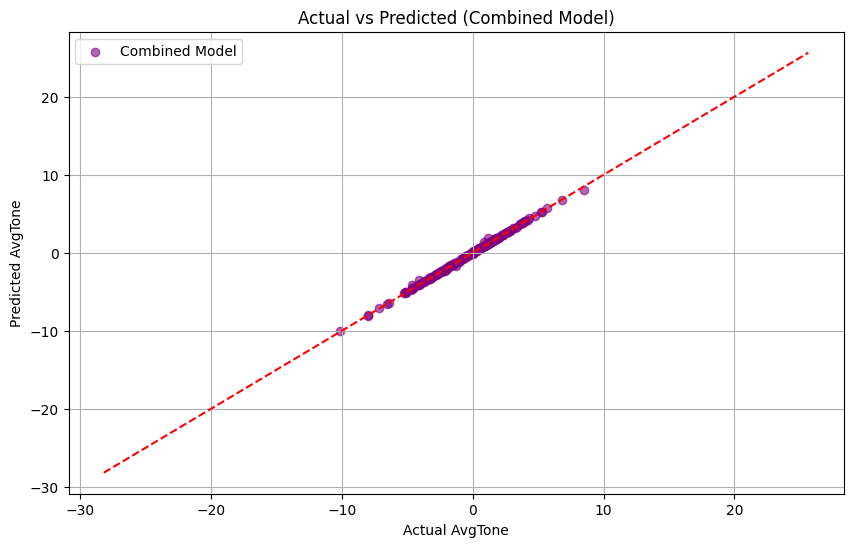

In [ ]:
# Combine Predictions from XGBoost and LSTM
combined_pred = (0.6 * y_pred_xgb + 0.4 * y_pred_lstm)  # Example weighted averaging


# Evaluate Combined Model
mae_combined = mean_absolute_error(y_test, combined_pred)
print(f"Combined Model MAE: {mae_combined:.4f}")

# Scatter Plot for Combined Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test.values[:subset], combined_pred[:subset], label='Combined Model', alpha=0.6, color='purple')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Perfect prediction line
plt.title('Actual vs Predicted (Combined Model)')
plt.xlabel('Actual AvgTone')
plt.ylabel('Predicted AvgTone')
plt.legend()
plt.grid()
plt.show()

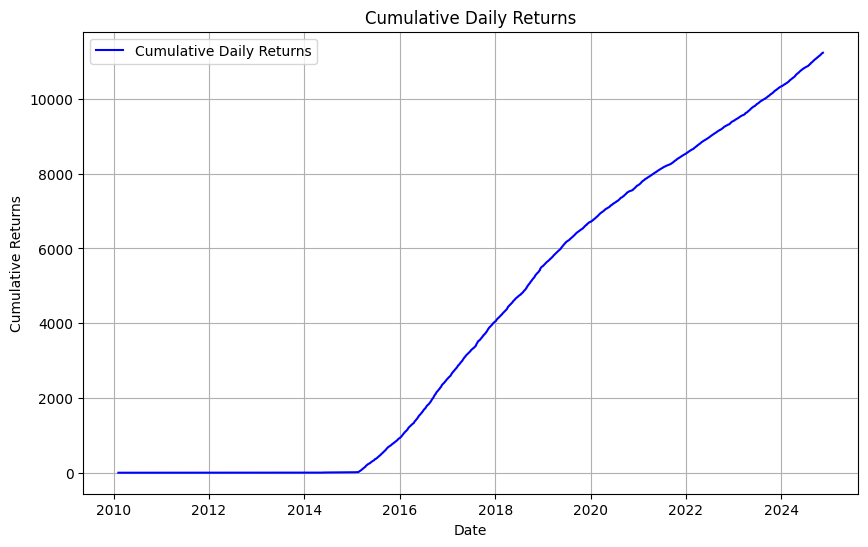

In [ ]:
# Aggregate returns (e.g., daily average)
data_test['Date'] = data['SQLDATE'].iloc[X_test.index]
daily_returns = data_test.groupby(data_test['Date'].dt.date)['Returns'].sum()

plt.figure(figsize=(10, 6))
daily_returns.cumsum().plot(label='Cumulative Daily Returns', color='blue')
plt.title('Cumulative Daily Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.show()

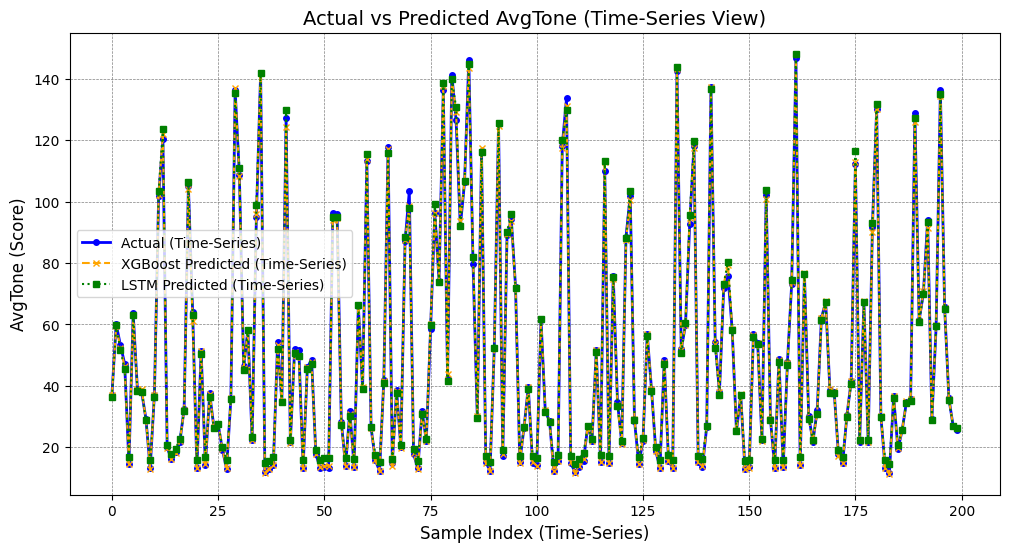

In [ ]:
# ---------- PART 3: SIMULATED TRADING STRATEGY ----------
# Combine predictions for strategy analysis
# Plot a subset of data for clarity
# Subset size for clarity
subset = 200

# Create the plot
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(y_test.values[:subset], label='Actual (Time-Series)', color='blue', marker='o', markersize=4, linewidth=2)

# Plot XGBoost predictions
plt.plot(y_pred_xgb[:subset], label='XGBoost Predicted (Time-Series)', color='orange', marker='x', linestyle='--', markersize=4)

# Plot LSTM predictions
plt.plot(y_pred_lstm[:subset], label='LSTM Predicted (Time-Series)', color='green', marker='s', linestyle=':', markersize=4)

# Add a title and axis labels
plt.title('Actual vs Predicted AvgTone (Time-Series View)', fontsize=14)
plt.xlabel('Sample Index (Time-Series)', fontsize=12)
plt.ylabel('AvgTone (Score)', fontsize=12)

# Add a legend
plt.legend(fontsize=10)

# Add a grid with a lighter style
plt.grid(color='gray', linestyle='--', linewidth=0.5)

# Show the plot
plt.show()



Use Yahoo Finance to fetch stock prices from 2024-11-15 to 2024-12-03 for the chosen companies.

In [ ]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Step 1: Load GDELT Data
file_path = '/content/drive/MyDrive/bq-results-20241115-074536-1731656781107/ANNG.csv'
gdelt_data = pd.read_csv(file_path)

# Ensure 'SQLDATE' is in datetime format
gdelt_data['SQLDATE'] = pd.to_datetime(gdelt_data['SQLDATE'])

name_mapping = {"APPLE INC": "APPLE"}  # Map "APPLE INC" to "APPLE"
gdelt_data['Actor1Name'] = gdelt_data['Actor1Name'].replace(name_mapping)

# Now, filter with normalized company names
anng_companies = ['GOOGLE', 'NETFLIX', 'NVIDIA', 'APPLE']
gdelt_data = gdelt_data[gdelt_data['Actor1Name'].isin(anng_companies)]

# Feature Engineering
gdelt_data['Lag_1'] = gdelt_data.groupby('Actor1Name')['AvgTone'].shift(1)
gdelt_data['Lag_2'] = gdelt_data.groupby('Actor1Name')['AvgTone'].shift(2)
gdelt_data['Rolling_Mean'] = gdelt_data.groupby('Actor1Name')['AvgTone'].rolling(3).mean().reset_index(0, drop=True)
gdelt_data = gdelt_data.dropna()

# Step 2: Fetch Stock Prices for ANNG Companies
def fetch_stock_data(ticker, start_date="2010-01-01", end_date="2024-11-15"):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data.reset_index(inplace=True)
    stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in stock_data.columns]  # Flatten MultiIndex
    stock_data.rename(columns={"Date": "SQLDATE", "Close": f"{ticker}_Close"}, inplace=True)
    stock_data['SQLDATE'] = pd.to_datetime(stock_data['SQLDATE']).dt.tz_localize(None)
    return stock_data[['SQLDATE', f"{ticker}_Close"]]

# Fetch data for each company
stock_data_google = fetch_stock_data("GOOG")
stock_data_netflix = fetch_stock_data("NFLX")
stock_data_nvidia = fetch_stock_data("NVDA")
stock_data_apple = fetch_stock_data("AAPL")

# Merge all stock data
all_stock_data = stock_data_google.merge(stock_data_netflix, on="SQLDATE", how="outer")
all_stock_data = all_stock_data.merge(stock_data_nvidia, on="SQLDATE", how="outer")
all_stock_data = all_stock_data.merge(stock_data_apple, on="SQLDATE", how="outer")

# Merge with GDELT data
merged_data = pd.merge(gdelt_data, all_stock_data, on="SQLDATE", how="inner")

# Step 3: Handle duplicate columns for Google stock prices
if 'GOOG_Close_y' in merged_data.columns and (merged_data['GOOG_Close_x'] == merged_data['GOOG_Close_y']).all():
    merged_data = merged_data.drop(columns=['GOOG_Close_y'])
    merged_data.rename(columns={'GOOG_Close_x': 'GOOG_Close'}, inplace=True)

# Display merged data for verification
print("Cleaned Merged Data:")
print(merged_data.head())

# Step 4: Prepare data for modeling
X = merged_data[['Lag_1', 'Lag_2', 'Rolling_Mean']]  # Features
y = merged_data[['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']].mean(axis=1)  # Average stock prices

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, eta=0.1)
model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae:.4f}")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Cleaned Merged Data:
   col_4  GLOBALEVENTID    SQLDATE Actor1Name   AvgTone     Lag_1     Lag_2  \
0      2     1028793661 2022-02-17     GOOGLE  1.125704  7.643312  1.379310   
1      3     1094907719 2023-04-11     GOOGLE -5.882353  1.125704  7.643312   
2      5      539188254 2016-05-11     GOOGLE  2.083333 -5.882353  1.125704   
3      6      862272632 2019-07-29     GOOGLE  1.088090  2.083333 -5.882353   
4      7      431145316 2015-05-06     GOOGLE -0.283286  1.088090  2.083333   

   Rolling_Mean  GOOG_Close  NFLX_Close  NVDA_Close  AAPL_Close  
0      3.382775  132.308502  386.670013   24.507000  168.880005  
1      0.962221  106.120003  338.209991   27.169001  160.800003  
2     -0.891105   35.764500   90.019997    0.901500   23.127501  
3     -0.903643   61.970501  332.700012    4.370500   52.419998  
4      0.962712   26.211000   80.077141    0.552500   31.252501  
Mean Absolute Error: 57.5165


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<ipython-input-23-bb057f7e6697>:41: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  all_stock_data = stock_data_google.merge(stock_data_netflix, on="SQLDATE", how="outer")
<ipython-input-23-bb057f7e6697>:42: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  all_stock_data = all_stock_data.merge(stock_data_nvidia, on="SQLDATE", how="outer")
<ipython-input-23-bb057f7e6697>:43: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  all_stock_data = all_stock_data.merge(stock_data_apple, on="SQLDATE", how="outer")



Training model for GOOGLE...
Mean Absolute Error for GOOGLE (Original Scale): 32.1285

Training model for NETFLIX...
Mean Absolute Error for NETFLIX (Original Scale): 149.5762

Training model for NVIDIA...
Mean Absolute Error for NVIDIA (Original Scale): 14.0921

Training model for APPLE INC...
Mean Absolute Error for APPLE INC (Original Scale): 49.9445


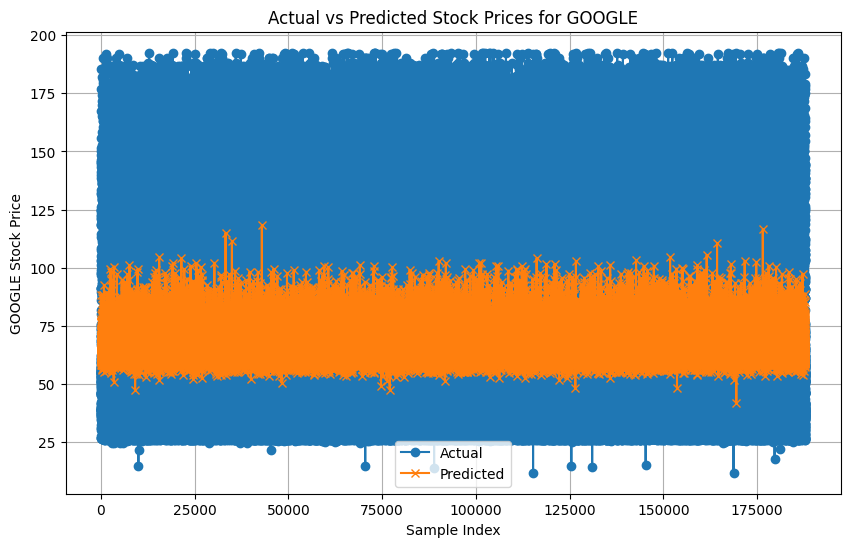

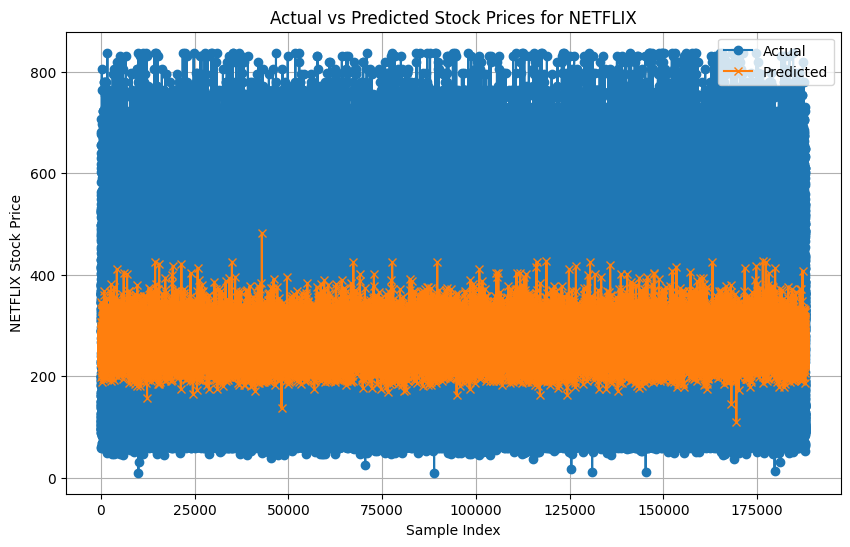

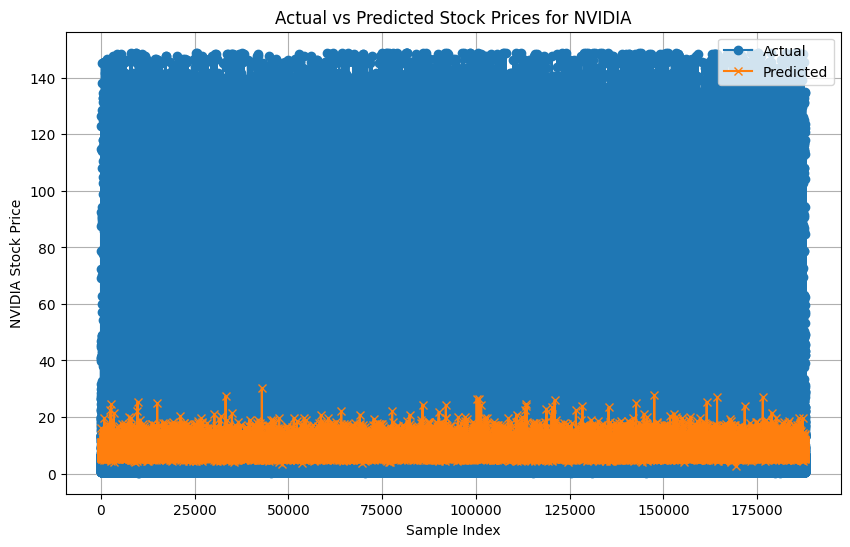

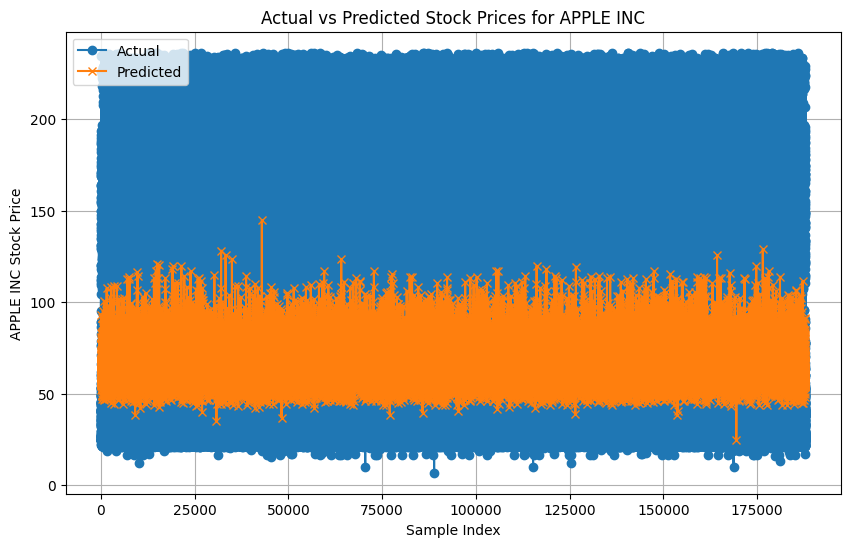


Forecasting future prices for GOOGLE...

Forecasting future prices for NETFLIX...

Forecasting future prices for NVIDIA...

Forecasting future prices for APPLE INC...

Forecasted Prices for GOOGLE:
     SQLDATE  Forecasted_Price
0 2024-11-16         63.586933
1 2024-11-17         69.311440
2 2024-11-18         80.142845
3 2024-11-19         80.521629
4 2024-11-20         78.394279
5 2024-11-21         83.239494
6 2024-11-22         83.239494
7 2024-11-23         83.239494
8 2024-11-24         83.239494
9 2024-11-25         83.239494

Forecasted Prices for NETFLIX:
     SQLDATE  Forecasted_Price
0 2024-11-16        255.501831
1 2024-11-17        260.978271
2 2024-11-18        316.283630
3 2024-11-19        339.484283
4 2024-11-20        340.829956
5 2024-11-21        345.556976
6 2024-11-22        345.556976
7 2024-11-23        345.556976
8 2024-11-24        345.556976
9 2024-11-25        345.556976

Forecasted Prices for NVIDIA:
     SQLDATE  Forecasted_Price
0 2024-11-16         14.1

In [ ]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Step 1: Load GDELT Data
file_path = '/content/drive/MyDrive/bq-results-20241115-074536-1731656781107/ANNG.csv'
gdelt_data = pd.read_csv(file_path)

# Ensure 'SQLDATE' is in datetime format
gdelt_data['SQLDATE'] = pd.to_datetime(gdelt_data['SQLDATE'])

# Filter for ANNG companies and sort by date
anng_companies = ['GOOGLE', 'NETFLIX', 'NVIDIA', 'APPLE INC']
gdelt_data = gdelt_data[gdelt_data['Actor1Name'].isin(anng_companies)].sort_values(by=['SQLDATE', 'Actor1Name'])

# Feature Engineering
gdelt_data['Lag_1'] = gdelt_data.groupby('Actor1Name')['AvgTone'].shift(1)
gdelt_data['Lag_2'] = gdelt_data.groupby('Actor1Name')['AvgTone'].shift(2)
gdelt_data['Rolling_Mean'] = gdelt_data.groupby('Actor1Name')['AvgTone'].rolling(3).mean().reset_index(0, drop=True)
gdelt_data = gdelt_data.dropna()

# Step 2: Fetch Stock Prices for ANNG Companies
def fetch_stock_data(ticker, start_date="2010-01-01", end_date="2024-11-15"):
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    stock_data.reset_index(inplace=True)
    stock_data.rename(columns={"Date": "SQLDATE", "Close": f"{ticker}_Close"}, inplace=True)
    stock_data['SQLDATE'] = pd.to_datetime(stock_data['SQLDATE']).dt.tz_localize(None)
    return stock_data[['SQLDATE', f"{ticker}_Close"]]

# Fetch data for each company
stock_data_google = fetch_stock_data("GOOG")
stock_data_netflix = fetch_stock_data("NFLX")
stock_data_nvidia = fetch_stock_data("NVDA")
stock_data_apple = fetch_stock_data("AAPL")

# Merge all stock data
all_stock_data = stock_data_google.merge(stock_data_netflix, on="SQLDATE", how="outer")
all_stock_data = all_stock_data.merge(stock_data_nvidia, on="SQLDATE", how="outer")
all_stock_data = all_stock_data.merge(stock_data_apple, on="SQLDATE", how="outer")

# Flatten MultiIndex columns in all_stock_data (if any)
all_stock_data.columns = [col[0] if isinstance(col, tuple) else col for col in all_stock_data.columns]

# Merge with GDELT data
merged_data = pd.merge(gdelt_data, all_stock_data, on="SQLDATE", how="inner")

# Step 3: Log Transform for Stability
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'Log_{col}'] = np.log1p(merged_data[col])

# Step 4: Prepare data for modeling
X = merged_data[['Lag_1', 'Lag_2', 'Rolling_Mean']]  # Features

# Initialize a dictionary to store results for each company
results = {}

for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nTraining model for {company}...")

    # Target variable for the current company
    y = merged_data[stock_column]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, eta=0.1)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse transform MAE
    print(f"Mean Absolute Error for {company} (Original Scale): {mae:.4f}")

    # Store the model and MAE
    results[company] = {
        "model": model,
        "mae": mae,
        "y_test": y_test,
        "y_pred": y_pred
    }

# Step 5: Visualize Results for Each Company
for company, result in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(np.expm1(result['y_test'].values), label="Actual", marker="o")
    plt.plot(np.expm1(result['y_pred']), label="Predicted", marker="x")
    plt.title(f"Actual vs Predicted Stock Prices for {company}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{company} Stock Price")
    plt.legend()
    plt.grid()
    plt.show()

# Step 6: Forecast Future Prices for Each Company
forecast_horizon = 10  # Predict for the next 10 days
forecast_results = {}

for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nForecasting future prices for {company}...")

    # Prepare the latest GDELT features
    company_gdelt = gdelt_data[gdelt_data['Actor1Name'] == company]

    # Check if GDELT data is available for the company
    if company_gdelt.empty:
        print(f"No GDELT data available for {company}. Skipping forecast.")
        continue

    # Retrieve the most recent row of GDELT data
    try:
        latest_gdelt = company_gdelt.iloc[-1]  # Most recent GDELT data
    except IndexError:
        print(f"Error: No data available for {company}. Skipping forecast.")
        continue

    latest_features = latest_gdelt[['Lag_1', 'Lag_2', 'Rolling_Mean']].values.reshape(1, -1)

    # Retrieve the model
    model = results[company]["model"]

    # Generate forecasts
    forecasted_prices = []
    for _ in range(forecast_horizon):
        pred_price_log = model.predict(latest_features)[0]
        forecasted_prices.append(np.expm1(pred_price_log))  # Inverse transform
        # Update lag features for the next prediction
        latest_features = np.roll(latest_features, -1, axis=1)
        latest_features[0, -1] = pred_price_log

    # Store the forecasts
    forecast_dates = pd.date_range(start='2024-11-16', periods=forecast_horizon, freq='D')
    forecast_results[company] = pd.DataFrame({'SQLDATE': forecast_dates, 'Forecasted_Price': forecasted_prices})

# Display forecast results for each company
for company, forecast_df in forecast_results.items():
    print(f"\nForecasted Prices for {company}:")
    print(forecast_df)


In [ ]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV





# Step 1: Load GDELT Data
file_path = '/content/drive/MyDrive/bq-results-20241115-074536-1731656781107/ANNG.csv'
gdelt_data = pd.read_csv(file_path)

# Ensure 'SQLDATE' is in datetime format
gdelt_data['SQLDATE'] = pd.to_datetime(gdelt_data['SQLDATE'])

# Normalize "APPLE INC" to "APPLE" in Actor1Name
name_mapping = {"APPLE INC": "APPLE"}
gdelt_data['Actor1Name'] = gdelt_data['Actor1Name'].replace(name_mapping)

# Filter for ANNG companies
anng_companies = ['GOOGLE', 'NETFLIX', 'NVIDIA', 'APPLE']
gdelt_data = gdelt_data[gdelt_data['Actor1Name'].isin(anng_companies)].sort_values(by=['SQLDATE', 'Actor1Name'])

# Feature Engineering: Add lagged features and rolling mean
gdelt_data['Lag_1'] = gdelt_data.groupby('Actor1Name')['AvgTone'].shift(1)
gdelt_data['Lag_2'] = gdelt_data.groupby('Actor1Name')['AvgTone'].shift(2)
gdelt_data['Rolling_Mean'] = gdelt_data.groupby('Actor1Name')['AvgTone'].rolling(3).mean().reset_index(0, drop=True)
gdelt_data = gdelt_data.dropna()

In [ ]:
def fetch_stock_data(ticker, start_date="2010-01-01", end_date="2024-11-15"):
    # Download stock data
    stock_data = yf.download(ticker, start=start_date, end=end_date, auto_adjust=True)
    stock_data.reset_index(inplace=True)

    # Flatten MultiIndex columns if they exist
    if isinstance(stock_data.columns, pd.MultiIndex):
        stock_data.columns = ['_'.join(col).strip('_') for col in stock_data.columns]

    # Debug: Print columns to ensure expected structure
    print(f"Ticker: {ticker} - Columns: {stock_data.columns.tolist()}")

    # Locate and rename 'Close' column
    close_col = [col for col in stock_data.columns if "Close" in col]
    if len(close_col) != 1:
        raise KeyError(f"Expected exactly one 'Close' column, but found {len(close_col)}. Columns: {stock_data.columns.tolist()}")
    close_col = close_col[0]

    stock_data.rename(columns={close_col: f"{ticker}_Close", "Date": "SQLDATE"}, inplace=True)
    stock_data['SQLDATE'] = pd.to_datetime(stock_data['SQLDATE'])

    # Validate SQLDATE
    if stock_data['SQLDATE'].isnull().any():
        raise ValueError(f"Null SQLDATE values found for {ticker}. Data: {stock_data.head()}")

    # Return only the necessary columns
    return stock_data[['SQLDATE', f"{ticker}_Close"]]

    # Fetch data for each company
try:
    stock_data_google = fetch_stock_data("GOOG")
    stock_data_netflix = fetch_stock_data("NFLX")
    stock_data_nvidia = fetch_stock_data("NVDA")
    stock_data_apple = fetch_stock_data("AAPL")
except (KeyError, ValueError) as e:
    print(f"Error encountered: {e}")
    raise


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker: GOOG - Columns: ['Date', 'Close_GOOG', 'High_GOOG', 'Low_GOOG', 'Open_GOOG', 'Volume_GOOG']
Ticker: NFLX - Columns: ['Date', 'Close_NFLX', 'High_NFLX', 'Low_NFLX', 'Open_NFLX', 'Volume_NFLX']
Ticker: NVDA - Columns: ['Date', 'Close_NVDA', 'High_NVDA', 'Low_NVDA', 'Open_NVDA', 'Volume_NVDA']


[*********************100%***********************]  1 of 1 completed

Ticker: AAPL - Columns: ['Date', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL', 'Volume_AAPL']



Training model for GOOGLE...
Mean Absolute Error for GOOGLE (Original Scale): 0.1131

Training model for NETFLIX...
Mean Absolute Error for NETFLIX (Original Scale): 0.5591

Training model for NVIDIA...
Mean Absolute Error for NVIDIA (Original Scale): 0.0743

Training model for APPLE...
Mean Absolute Error for APPLE (Original Scale): 0.1355


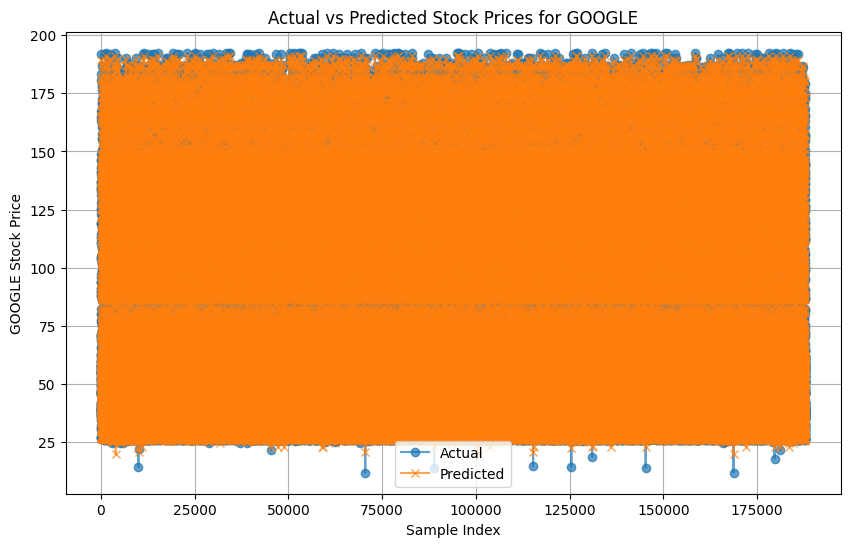

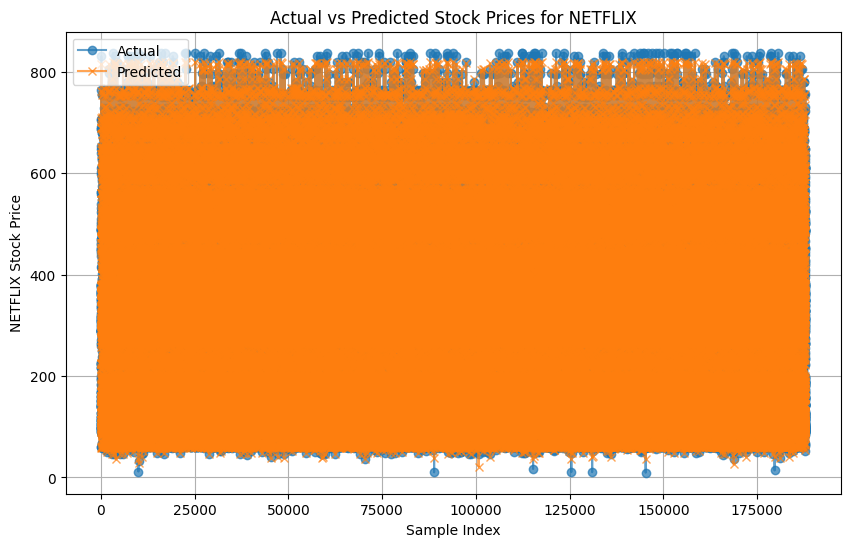

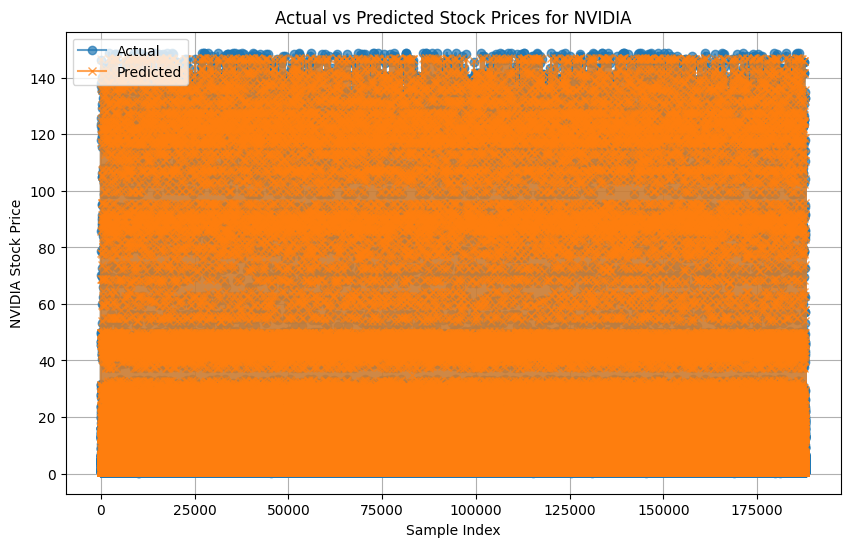

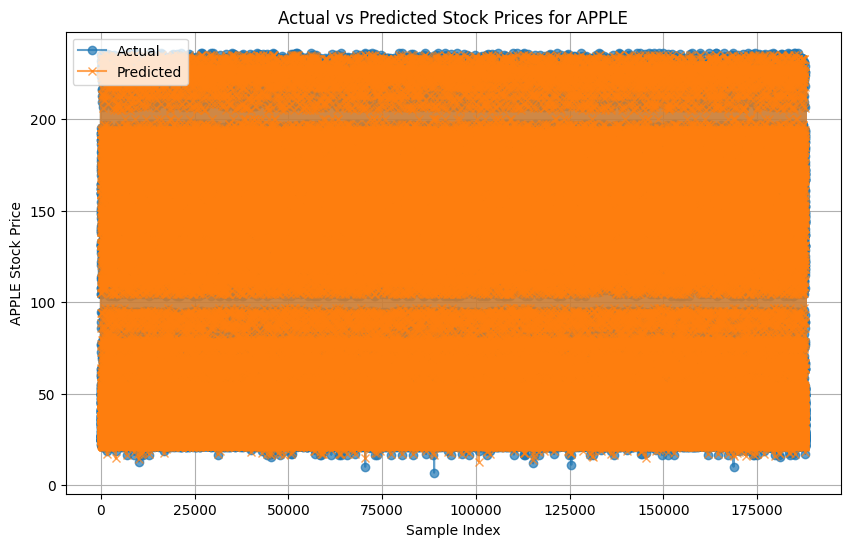


Forecasting future prices for GOOGLE...

Forecasting future prices for NETFLIX...

Forecasting future prices for NVIDIA...

Forecasting future prices for APPLE...

Forecasted Prices for GOOGLE:
     SQLDATE  Forecasted_Price
0 2024-11-16        177.977417
1 2024-11-17        180.099075
2 2024-11-18        187.510437
3 2024-11-19        187.492462
4 2024-11-20        189.949387
5 2024-11-21        186.608688
6 2024-11-22        170.997757
7 2024-11-23        172.504623
8 2024-11-24        189.531021
9 2024-11-25        189.531021

Forecasted Prices for NETFLIX:
     SQLDATE  Forecasted_Price
0 2024-11-16        818.329712
1 2024-11-17        808.933655
2 2024-11-18        780.787109
3 2024-11-19        775.866272
4 2024-11-20        725.910461
5 2024-11-21        725.494629
6 2024-11-22        764.941772
7 2024-11-23        782.534790
8 2024-11-24        799.974548
9 2024-11-25        799.974548

Forecasted Prices for NVIDIA:
     SQLDATE  Forecasted_Price
0 2024-11-16        146.49079

In [ ]:
from sklearn.preprocessing import StandardScaler

# Step 3: Log Transform for Stability
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'Log_{col}'] = np.log1p(merged_data[col])

# Add lagged stock prices as features
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'{col}_Lag1'] = merged_data[col].shift(1)
    merged_data[f'{col}_Lag2'] = merged_data[col].shift(2)

# Drop rows with NaN values caused by lagging
merged_data = merged_data.dropna()

# Define feature columns
features = ['Lag_1', 'Lag_2', 'Rolling_Mean',
            'GOOG_Close_Lag1', 'GOOG_Close_Lag2',
            'NFLX_Close_Lag1', 'NFLX_Close_Lag2',
            'NVDA_Close_Lag1', 'NVDA_Close_Lag2',
            'AAPL_Close_Lag1', 'AAPL_Close_Lag2']

# Standardize features
scaler = StandardScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Step 4: Prepare data for modeling
results = {}  # To store results for each company

for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nTraining model for {company}...")

    # Define the target variable
    y = merged_data[stock_column]
    X = merged_data[features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, eta=0.1)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse log transform for error calculation
    print(f"Mean Absolute Error for {company} (Original Scale): {mae:.4f}")

    # Store results
    results[company] = {"model": model, "mae": mae, "y_test": y_test, "y_pred": y_pred}

# Step 5: Visualize Results for Each Company
for company, result in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(np.expm1(result['y_test'].values), label="Actual", marker="o", alpha=0.7)
    plt.plot(np.expm1(result['y_pred']), label="Predicted", marker="x", alpha=0.7)
    plt.title(f"Actual vs Predicted Stock Prices for {company}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{company} Stock Price")
    plt.legend()
    plt.grid()
    plt.show()

# Step 6: Forecast Future Prices for Each Company
forecast_horizon = 10
forecast_results = {}

for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nForecasting future prices for {company}...")

    # Use the latest features for forecasting
    latest_features = merged_data[features].iloc[-1].values.reshape(1, -1)
    model = results[company]["model"]

    forecasted_prices = []
    for _ in range(forecast_horizon):
        pred_price_log = model.predict(latest_features)[0]
        forecasted_prices.append(np.expm1(pred_price_log))  # Inverse log transform
        # Update features with predictions
        latest_features = np.roll(latest_features, -1, axis=1)
        latest_features[0, -1] = pred_price_log  # Replace the last feature with the prediction

    # Create a DataFrame for forecasted prices
    forecast_dates = pd.date_range(start='2024-11-16', periods=forecast_horizon, freq='D')
    forecast_results[company] = pd.DataFrame({'SQLDATE': forecast_dates, 'Forecasted_Price': forecasted_prices})

# Display forecast results
for company, forecast_df in forecast_results.items():
    print(f"\nForecasted Prices for {company}:")
    print(forecast_df)


In [ ]:
import yfinance as yf

def get_stock_prices(tickers, start_date, end_date):
  """
  Fetches historical stock closing prices for specified tickers.

  Args:
    tickers: A list of stock tickers (e.g., ['NVDA', 'GOOG']).
    start_date: The start date for the price data (YYYY-MM-DD).
    end_date: The end date for the price data (YYYY-MM-DD).

  Returns:
    A pandas DataFrame with the closing prices for each ticker.
  """
  data = yf.download(tickers, start=start_date, end=end_date)
  return data['Close']

# Specify the tickers, start date, and end date
tickers = ['NVDA', 'GOOG', 'NFLX', 'AAPL']
start_date = '2024-11-15'
end_date = '2024-11-25'

# Fetch the stock prices
stock_prices = get_stock_prices(tickers, start_date, end_date)

# Print or further process the data
stock_prices

[*********************100%***********************]  4 of 4 completed


Ticker                           AAPL        GOOG        NFLX        NVDA
Date                                                                     
2024-11-15 00:00:00+00:00  225.000000  173.889999  823.960022  141.979996
2024-11-18 00:00:00+00:00  228.020004  176.800003  847.049988  140.149994
2024-11-19 00:00:00+00:00  228.279999  179.580002  871.320007  147.009995
2024-11-20 00:00:00+00:00  229.000000  177.330002  883.849976  145.889999
2024-11-21 00:00:00+00:00  228.520004  169.240005  897.479980  146.669998
2024-11-22 00:00:00+00:00  229.869995  166.570007  897.789978  141.949997

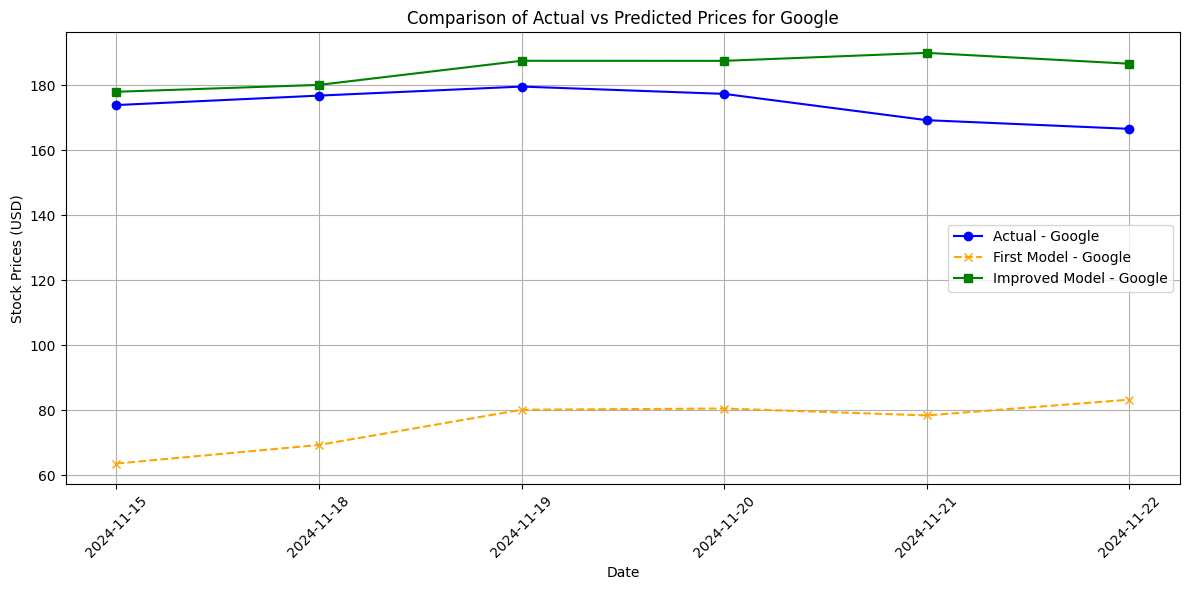

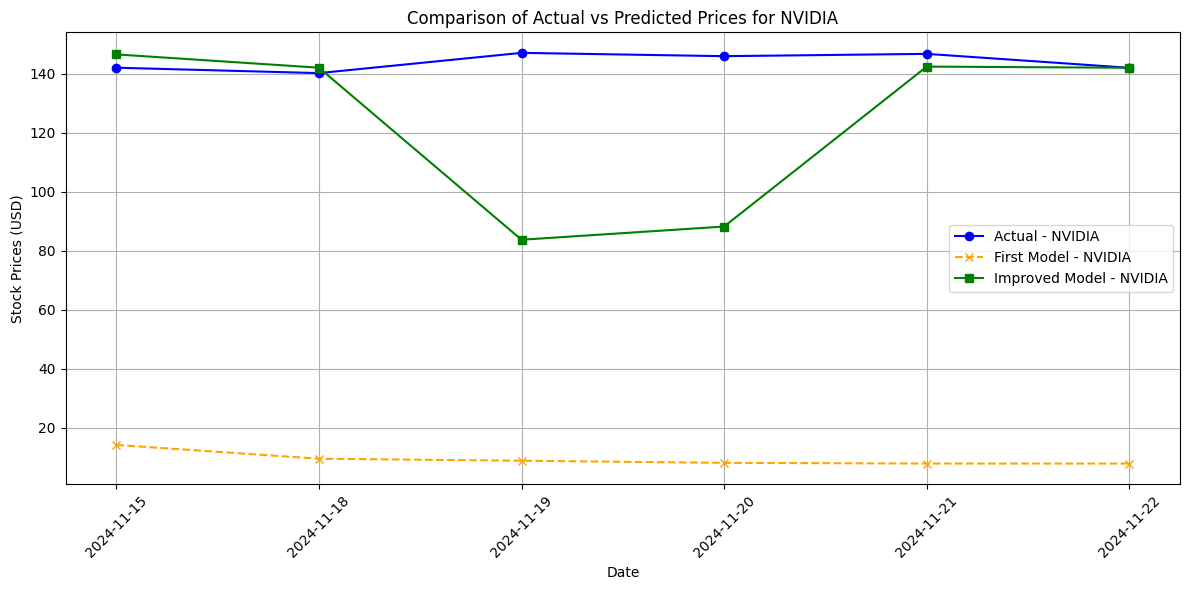

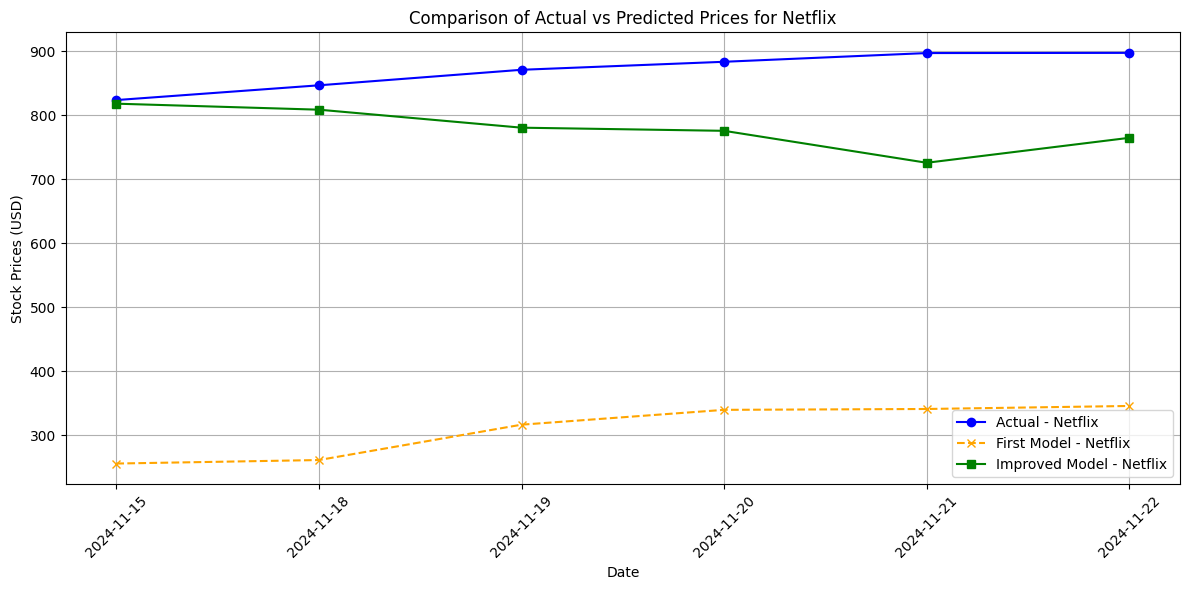

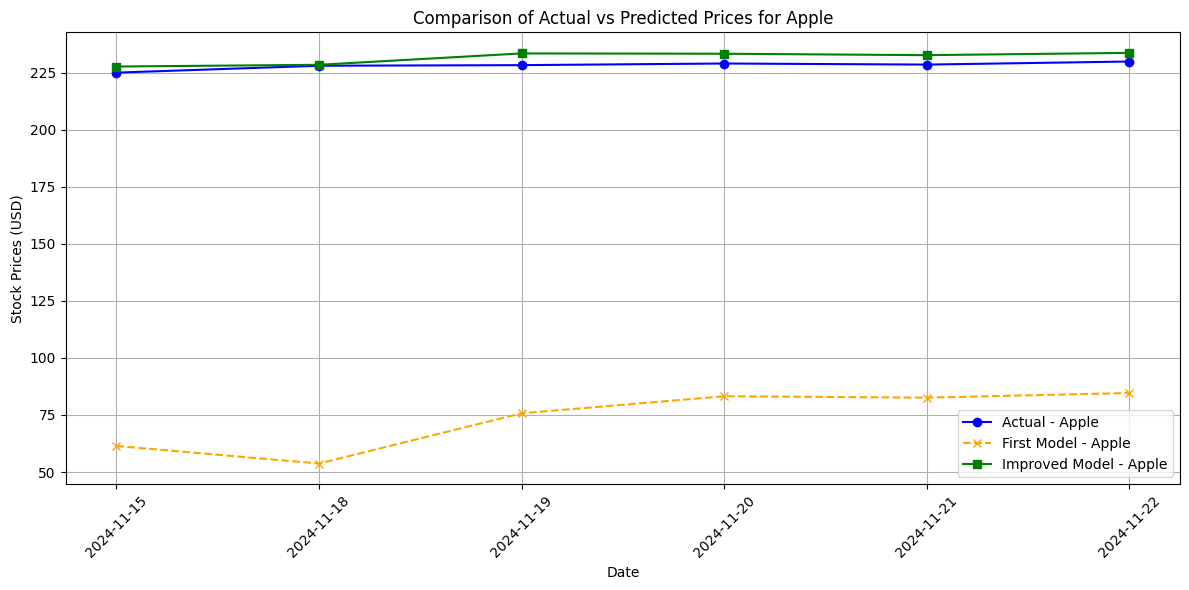

In [ ]:
import matplotlib.pyplot as plt

# Dates for x-axis
forecast_dates = ['2024-11-15', '2024-11-18', '2024-11-19', '2024-11-20',
                  '2024-11-21', '2024-11-22']

# Actual Prices
actual_google = [173.889999, 176.800003, 179.580002, 177.330002, 169.240005, 166.570007]
actual_nvidia = [141.979996, 140.149994, 147.009995, 145.889999, 146.669998, 141.949997]
actual_netflix = [823.960022, 847.049988, 871.320007, 883.849976, 897.479980, 897.789978]
actual_apple = [225.000000, 228.020004, 228.279999, 229.000000, 228.520004, 229.869995]

# First Model Predictions
first_model_google = [63.586933, 69.311440, 80.142845, 80.521629, 78.394279, 83.239494]
first_model_nvidia = [14.149767, 9.467625, 8.790879, 8.069864, 7.834074, 7.834074]
first_model_netflix = [255.501831, 260.978271, 316.283630, 339.484283, 340.829956, 345.556976]
first_model_apple = [61.422836, 53.713943, 75.721413, 83.197128, 82.590790, 84.624107]

# Improved Model Predictions
accurate_model_google = [177.977417, 180.099075, 187.510437, 187.492462, 189.949387, 186.608688]
accurate_model_nvidia = [146.490799, 141.983047, 83.680367, 88.152962, 142.354706, 141.969147]
accurate_model_netflix = [818.329712, 808.933655, 780.787109, 775.866272, 725.910461, 764.941772]
accurate_model_apple = [227.674393, 228.432068, 233.414368, 233.278610, 232.656189, 233.659302]

# Plotting for Google
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_google, label="Actual - Google", color='blue', marker='o')
plt.plot(forecast_dates, first_model_google, label="First Model - Google", linestyle='--', marker='x', color='orange')
plt.plot(forecast_dates, accurate_model_google, label="Improved Model - Google", linestyle='-', marker='s', color='green')

plt.title("Comparison of Actual vs Predicted Prices for Google")
plt.xlabel("Date")
plt.ylabel("Stock Prices (USD)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting for NVIDIA
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_nvidia, label="Actual - NVIDIA", color='blue', marker='o')
plt.plot(forecast_dates, first_model_nvidia, label="First Model - NVIDIA", linestyle='--', marker='x', color='orange')
plt.plot(forecast_dates, accurate_model_nvidia, label="Improved Model - NVIDIA", linestyle='-', marker='s', color='green')

plt.title("Comparison of Actual vs Predicted Prices for NVIDIA")
plt.xlabel("Date")
plt.ylabel("Stock Prices (USD)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting for Netflix
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_netflix, label="Actual - Netflix", color='blue', marker='o')
plt.plot(forecast_dates, first_model_netflix, label="First Model - Netflix", linestyle='--', marker='x', color='orange')
plt.plot(forecast_dates, accurate_model_netflix, label="Improved Model - Netflix", linestyle='-', marker='s', color='green')

plt.title("Comparison of Actual vs Predicted Prices for Netflix")
plt.xlabel("Date")
plt.ylabel("Stock Prices (USD)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting for Apple
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_apple, label="Actual - Apple", color='blue', marker='o')
plt.plot(forecast_dates, first_model_apple, label="First Model - Apple", linestyle='--', marker='x', color='orange')
plt.plot(forecast_dates, accurate_model_apple, label="Improved Model - Apple", linestyle='-', marker='s', color='green')

plt.title("Comparison of Actual vs Predicted Prices for Apple")
plt.xlabel("Date")
plt.ylabel("Stock Prices (USD)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Training model for GOOGLE...
Mean Absolute Error for GOOGLE (Original Scale): 0.1121

Training model for NETFLIX...
Mean Absolute Error for NETFLIX (Original Scale): 0.5568

Training model for NVIDIA...
Mean Absolute Error for NVIDIA (Original Scale): 0.0739

Training model for APPLE...
Mean Absolute Error for APPLE (Original Scale): 0.1319


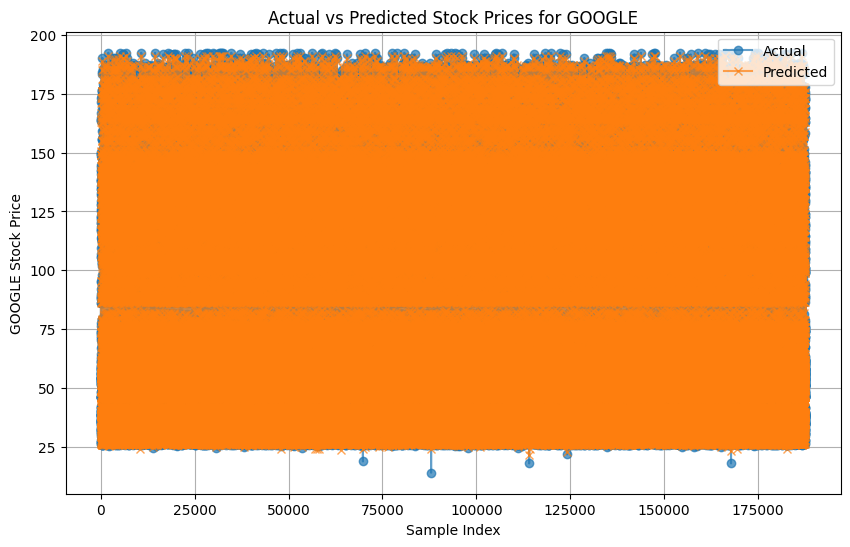

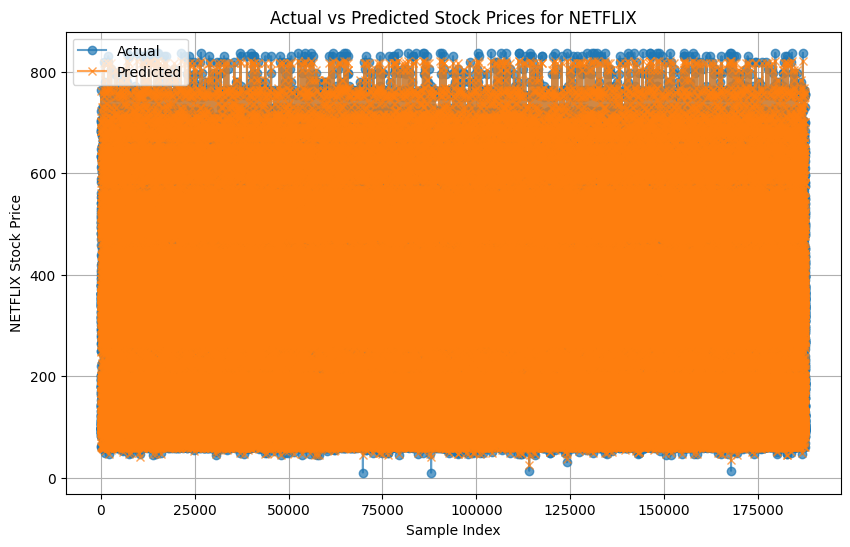

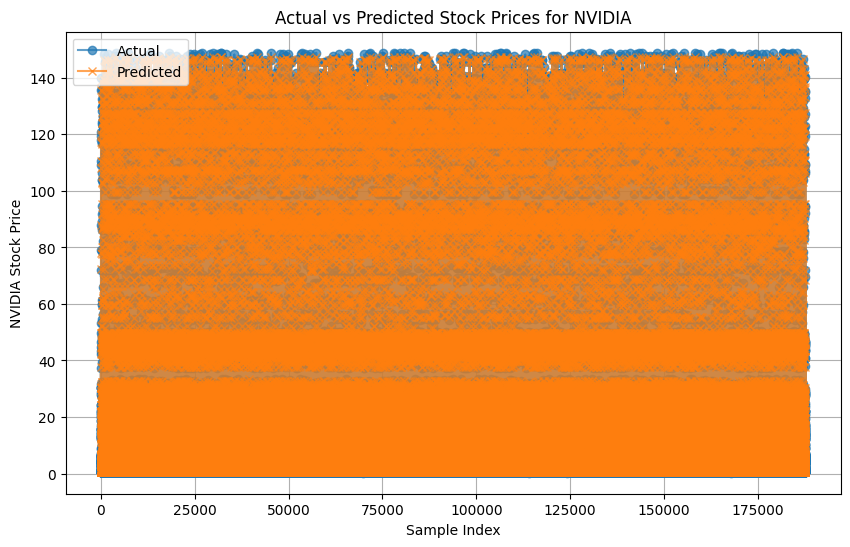

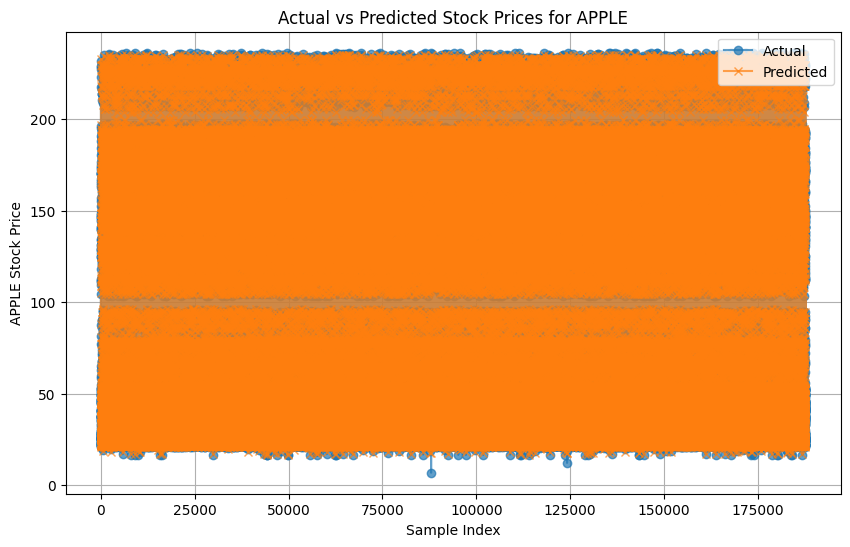


Forecasting future prices for GOOGLE...

Forecasting future prices for NETFLIX...

Forecasting future prices for NVIDIA...

Forecasting future prices for APPLE...

Forecasted Prices for GOOGLE:
     SQLDATE  Forecasted_Price
0 2024-11-16        177.793854
1 2024-11-17        179.116776
2 2024-11-18        188.741699
3 2024-11-19        188.985504
4 2024-11-20        190.441345
5 2024-11-21        187.702713
6 2024-11-22        171.086853
7 2024-11-23        172.212479
8 2024-11-24        189.956039
9 2024-11-25        189.956039

Forecasted Prices for NETFLIX:
     SQLDATE  Forecasted_Price
0 2024-11-16        821.401184
1 2024-11-17        804.061340
2 2024-11-18        780.896362
3 2024-11-19        778.655457
4 2024-11-20        722.270081
5 2024-11-21        730.170349
6 2024-11-22        763.654663
7 2024-11-23        781.744629
8 2024-11-24        799.286621
9 2024-11-25        799.286621

Forecasted Prices for NVIDIA:
     SQLDATE  Forecasted_Price
0 2024-11-16        146.54397

In [ ]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
# Step 3: Merge stock data with GDELT data

# Ensure 'SQLDATE' in both gdelt_data and stock data are in the same format and timezone
gdelt_data['SQLDATE'] = pd.to_datetime(gdelt_data['SQLDATE']).dt.tz_localize(None)  # Remove timezone info from GDELT data

# Loop through each stock_data and ensure SQLDATE has no timezone
for stock_data in [stock_data_google, stock_data_netflix, stock_data_nvidia, stock_data_apple]:
    stock_data['SQLDATE'] = pd.to_datetime(stock_data['SQLDATE']).dt.tz_localize(None)  # Remove timezone info from stock data

# Merge stock data with GDELT data
merged_data = gdelt_data
for stock_data in [stock_data_google, stock_data_netflix, stock_data_nvidia, stock_data_apple]:
    merged_data = merged_data.merge(stock_data, on='SQLDATE', how='left')

# Step 4: Log Transform for Stability
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'Log_{col}'] = np.log1p(merged_data[col])

# Add lagged stock prices as features
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'{col}_Lag1'] = merged_data[col].shift(1)
    merged_data[f'{col}_Lag2'] = merged_data[col].shift(2)

# Drop rows with NaN values caused by lagging
merged_data = merged_data.dropna()

# Define feature columns
features = ['Lag_1', 'Lag_2', 'Rolling_Mean',
            'GOOG_Close_Lag1', 'GOOG_Close_Lag2',
            'NFLX_Close_Lag1', 'NFLX_Close_Lag2',
            'NVDA_Close_Lag1', 'NVDA_Close_Lag2',
            'AAPL_Close_Lag1', 'AAPL_Close_Lag2']

# Standardize features
scaler = StandardScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Step 5: Prepare data for modeling
results = {}  # To store results for each company

for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nTraining model for {company}...")

    # Define the target variable
    y = merged_data[stock_column]
    X = merged_data[features]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train an XGBoost model
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=6, eta=0.1)
    model.fit(X_train, y_train)

    # Evaluate the model
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse log transform for error calculation
    print(f"Mean Absolute Error for {company} (Original Scale): {mae:.4f}")

    # Store results
    results[company] = {"model": model, "mae": mae, "y_test": y_test, "y_pred": y_pred}

# Step 6: Visualize Results for Each Company
for company, result in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(np.expm1(result['y_test'].values), label="Actual", marker="o", alpha=0.7)
    plt.plot(np.expm1(result['y_pred']), label="Predicted", marker="x", alpha=0.7)
    plt.title(f"Actual vs Predicted Stock Prices for {company}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{company} Stock Price")
    plt.legend()
    plt.grid()
    plt.show()

# Step 7: Forecast Future Prices for Each Company
forecast_horizon = 10
forecast_results = {}

for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nForecasting future prices for {company}...")

    # Use the latest features for forecasting
    latest_features = merged_data[features].iloc[-1].values.reshape(1, -1)
    model = results[company]["model"]

    forecasted_prices = []
    for _ in range(forecast_horizon):
        pred_price_log = model.predict(latest_features)[0]
        forecasted_prices.append(np.expm1(pred_price_log))  # Inverse log transform
        # Update features with predictions
        latest_features = np.roll(latest_features, -1, axis=1)
        latest_features[0, -1] = pred_price_log  # Replace the last feature with the prediction

    # Create a DataFrame for forecasted prices
    forecast_dates = pd.date_range(start='2024-11-16', periods=forecast_horizon, freq='D')
    forecast_results[company] = pd.DataFrame({'SQLDATE': forecast_dates, 'Forecasted_Price': forecasted_prices})

# Display forecast results
for company, forecast_df in forecast_results.items():
    print(f"\nForecasted Prices for {company}:")
    print(forecast_df)


<ipython-input-37-0f0ad9ed54fe>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data[f'{col}_Rolling_Mean_5'] = merged_data[col].rolling(window=5).mean().shift(1)
<ipython-input-37-0f0ad9ed54fe>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data[f'{col}_Volatility_5'] = merged_data[col].rolling(window=5).std().shift(1)
<ipython-input-37-0f0ad9ed54fe>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v


Training model for GOOGLE...
MAPE for GOOGLE: 0.0815
MAPE for GOOGLE: 0.0958
MAPE for GOOGLE: 0.0556
MAPE for GOOGLE: 0.2678
MAPE for GOOGLE: 0.0438

Training model for NETFLIX...
MAPE for NETFLIX: 0.1023
MAPE for NETFLIX: 0.3133
MAPE for NETFLIX: 0.0316
MAPE for NETFLIX: 0.0307
MAPE for NETFLIX: 0.0128

Training model for NVIDIA...
MAPE for NVIDIA: 0.4583
MAPE for NVIDIA: 0.1354
MAPE for NVIDIA: 0.0701
MAPE for NVIDIA: 0.2243
MAPE for NVIDIA: 0.4024

Training model for APPLE...
MAPE for APPLE: 0.0775
MAPE for APPLE: 0.1216
MAPE for APPLE: 0.1554
MAPE for APPLE: 0.1224
MAPE for APPLE: 0.0673


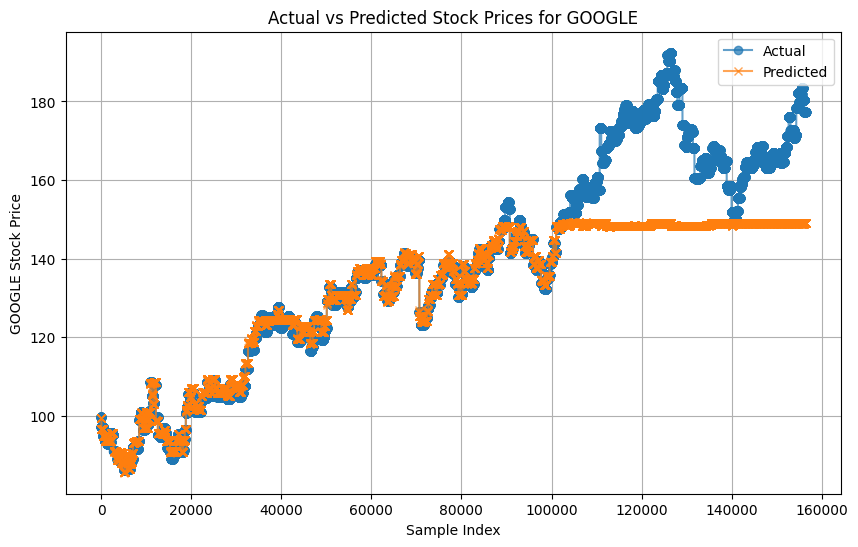

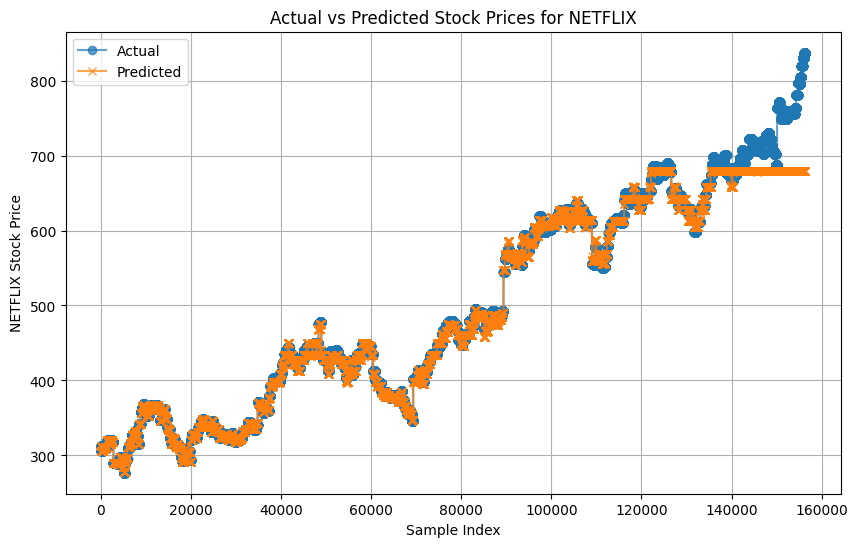

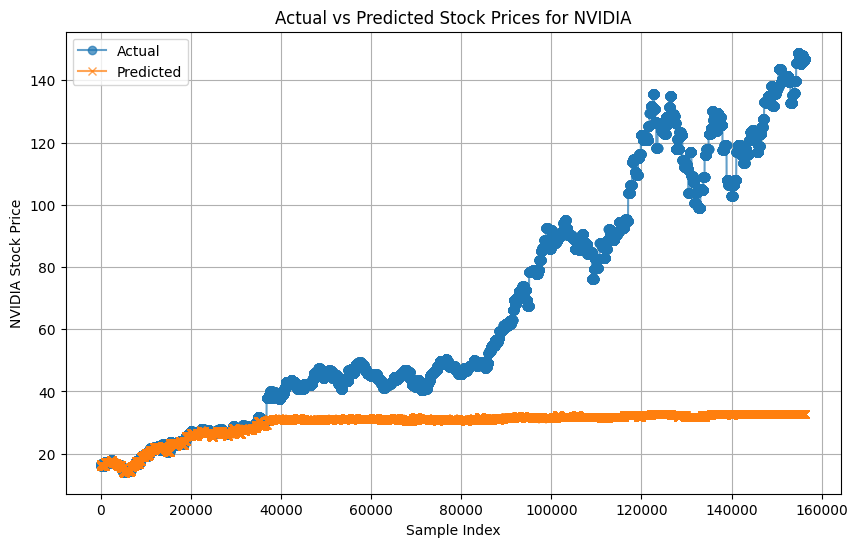

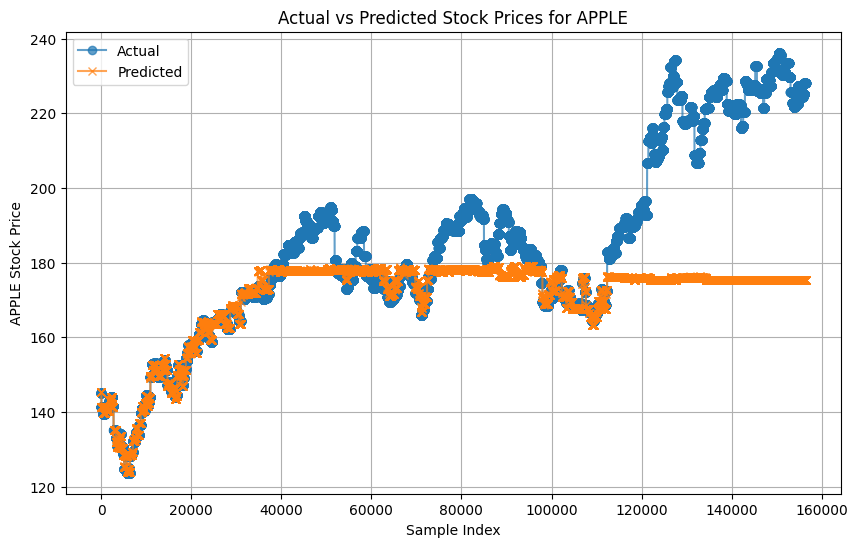


Forecasting future prices for GOOGLE...

Forecasting future prices for NETFLIX...

Forecasting future prices for NVIDIA...

Forecasting future prices for APPLE...

Forecasted Prices for GOOGLE:
     SQLDATE  Forecasted_Price
0 2024-11-16        148.966400
1 2024-11-17        131.950958
2 2024-11-18        149.010391
3 2024-11-19         30.598442
4 2024-11-20        148.966400
5 2024-11-21        130.374527
6 2024-11-22        149.024689
7 2024-11-23         30.764179
8 2024-11-24        148.966400
9 2024-11-25        131.035645

Forecasted Prices for NETFLIX:
     SQLDATE  Forecasted_Price
0 2024-11-16        679.013611
1 2024-11-17        617.175354
2 2024-11-18        677.479675
3 2024-11-19         77.383339
4 2024-11-20        679.011353
5 2024-11-21        614.107056
6 2024-11-22        677.226746
7 2024-11-23         76.458290
8 2024-11-24        679.011353
9 2024-11-25        615.594177

Forecasted Prices for NVIDIA:
     SQLDATE  Forecasted_Price
0 2024-11-16         32.78492

In [ ]:
import pandas as pd
import yfinance as yf
import xgboost as xgb
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Assuming merged_data is already loaded with your stock data
# Example: merged_data = pd.read_csv('your_data.csv')

# Feature Engineering: Add lag features, moving averages, and volatility measures

# Fix: Adding rolling mean and volatility separately for each stock
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'{col}_Rolling_Mean_5'] = merged_data[col].rolling(window=5).mean().shift(1)
    merged_data[f'{col}_Volatility_5'] = merged_data[col].rolling(window=5).std().shift(1)
    merged_data[f'{col}_Lag1'] = merged_data[col].shift(1)
    merged_data[f'{col}_Lag2'] = merged_data[col].shift(2)

# Drop NaN rows after creating rolling features and lags
merged_data.dropna(inplace=True)

# Features (using the most relevant columns)
features = ['GOOG_Close_Rolling_Mean_5', 'GOOG_Close_Volatility_5',
            'GOOG_Close_Lag1', 'GOOG_Close_Lag2',
            'NFLX_Close_Rolling_Mean_5', 'NFLX_Close_Volatility_5',
            'NFLX_Close_Lag1', 'NFLX_Close_Lag2',
            'NVDA_Close_Rolling_Mean_5', 'NVDA_Close_Volatility_5',
            'NVDA_Close_Lag1', 'NVDA_Close_Lag2',
            'AAPL_Close_Rolling_Mean_5', 'AAPL_Close_Volatility_5',
            'AAPL_Close_Lag1', 'AAPL_Close_Lag2']

# Scaling features (MinMaxScaler to avoid overfitting issues)
scaler = MinMaxScaler()
merged_data.loc[:, features] = scaler.fit_transform(merged_data[features])

# Results storage
results = {}

# Train-Test Split using TimeSeriesSplit for time-dependent data
tscv = TimeSeriesSplit(n_splits=5)

for company, stock_column in zip(['GOOGLE', 'NETFLIX', 'NVIDIA', 'APPLE'],
                                 ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nTraining model for {company}...")

    # Define target variable
    y = merged_data[stock_column]
    X = merged_data[features]

    # Train-test split using TimeSeriesSplit
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Train XGBoost model with default hyperparameters
        model = xgb.XGBRegressor(objective='reg:squarederror')
        model.fit(X_train, y_train)

        # Predict and evaluate
        y_pred = model.predict(X_test)

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = mean_absolute_percentage_error(np.expm1(y_test), np.expm1(y_pred))  # Exponentiate back to original scale
        print(f"MAPE for {company}: {mape:.4f}")

        # Store results for this split
        results[company] = {"model": model, "mape": mape, "y_test": y_test, "y_pred": y_pred}

# Visualizing Results for each Company
for company, result in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(np.expm1(result['y_test'].values), label="Actual", marker="o", alpha=0.7)
    plt.plot(np.expm1(result['y_pred']), label="Predicted", marker="x", alpha=0.7)
    plt.title(f"Actual vs Predicted Stock Prices for {company}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{company} Stock Price")
    plt.legend()
    plt.grid()
    plt.show()

# Forecasting with Updated Model
forecast_horizon = 10
forecast_results = {}

for company, stock_column in zip(['GOOGLE', 'NETFLIX', 'NVIDIA', 'APPLE'],
                                 ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nForecasting future prices for {company}...")

    model = results[company]["model"]
    latest_features = merged_data[features].iloc[-1].values.reshape(1, -1)

    forecasted_prices = []
    for _ in range(forecast_horizon):
        pred_price_log = model.predict(latest_features)[0]
        forecasted_prices.append(np.expm1(pred_price_log))  # Inverse log transform

        # Update features with new predicted price
        latest_features = np.roll(latest_features, -1, axis=1)
        latest_features[0, -1] = pred_price_log

    # Forecast results
    forecast_dates = pd.date_range(start='2024-11-16', periods=forecast_horizon, freq='D')
    forecast_results[company] = pd.DataFrame({'SQLDATE': forecast_dates, 'Forecasted_Price': forecasted_prices})

# Display forecasted prices
for company, forecast_df in forecast_results.items():
    print(f"\nForecasted Prices for {company}:")
    print(forecast_df)


This output took 1h 33m 30s to complete


Training model for GOOGLE...
Best Mean Absolute Error for GOOGLE (Original Scale): 3.7301

Training model for NETFLIX...
Best Mean Absolute Error for NETFLIX (Original Scale): 8.9719

Training model for NVIDIA...
Best Mean Absolute Error for NVIDIA (Original Scale): 0.7898

Training model for APPLE...


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Mean Absolute Error for APPLE (Original Scale): 2.7896


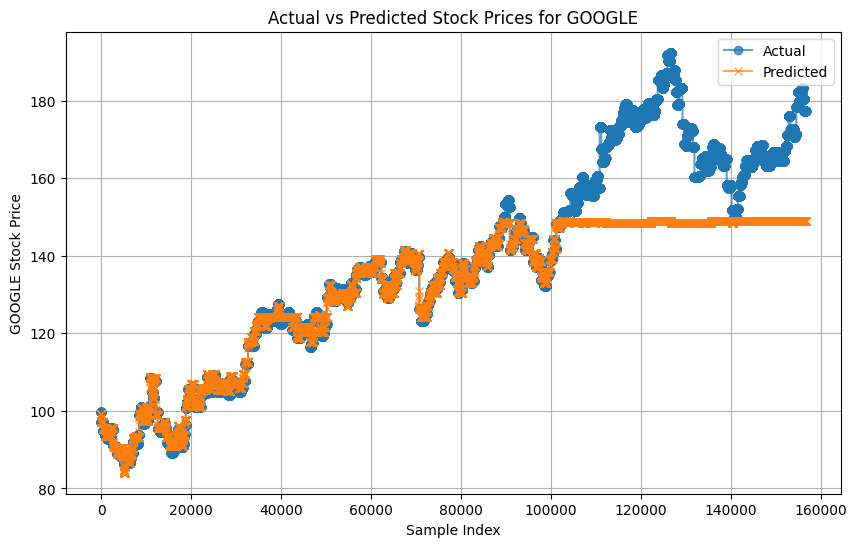

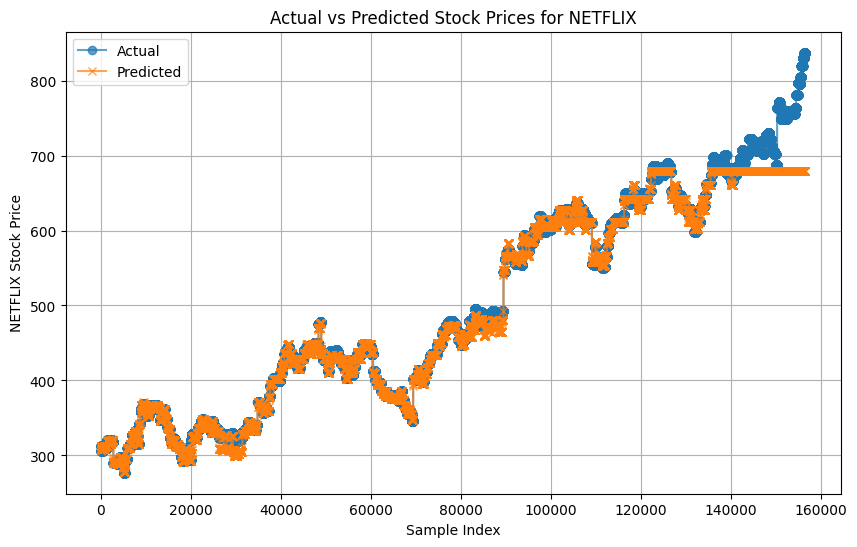

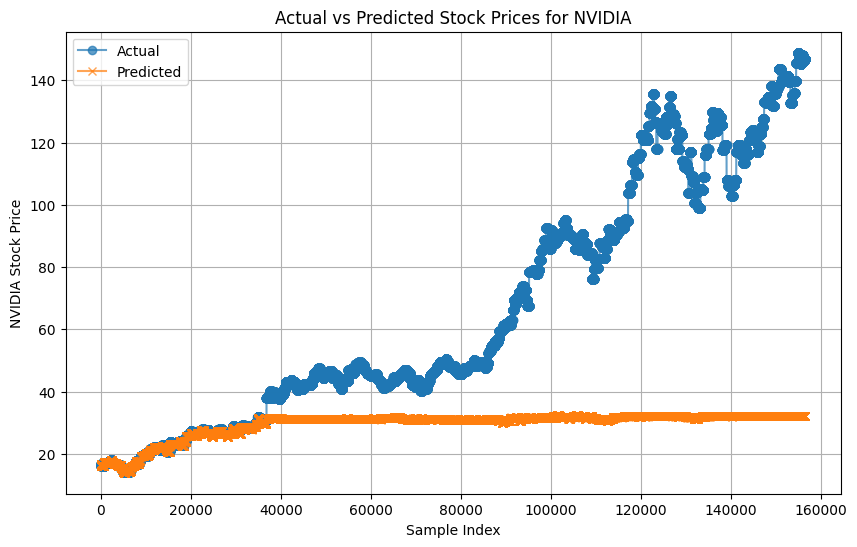

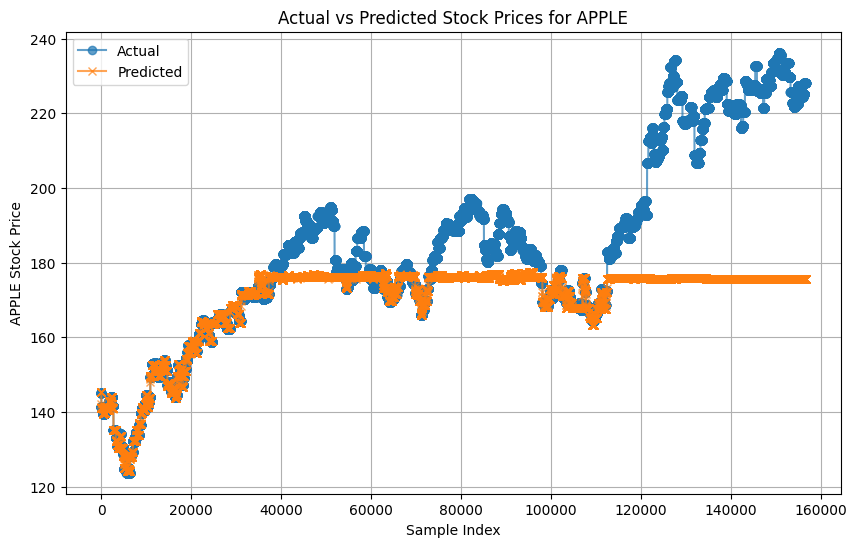


Forecasting future prices for GOOGLE...

Forecasting future prices for NETFLIX...

Forecasting future prices for NVIDIA...

Forecasting future prices for APPLE...

Forecasted Prices for GOOGLE:
     SQLDATE  Forecasted_Price
0 2024-11-16         38.714417
1 2024-11-17         38.714417
2 2024-11-18         38.714417
3 2024-11-19         38.714417
4 2024-11-20         38.714417
5 2024-11-21         38.714417
6 2024-11-22         38.714417
7 2024-11-23         38.714417
8 2024-11-24         38.714417
9 2024-11-25         38.714417

Forecasted Prices for NETFLIX:
     SQLDATE  Forecasted_Price
0 2024-11-16        679.010742
1 2024-11-17        679.010742
2 2024-11-18        679.010742
3 2024-11-19        679.010742
4 2024-11-20        679.010742
5 2024-11-21        679.010742
6 2024-11-22        679.010742
7 2024-11-23        679.010742
8 2024-11-24        679.010742
9 2024-11-25        679.010742

Forecasted Prices for NVIDIA:
     SQLDATE  Forecasted_Price
0 2024-11-16          7.13202

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Assuming `merged_data` and `anng_companies` are already defined in your environment.
# Load or preprocess `merged_data` and `anng_companies` before running this script.

# Step 1: Data Preprocessing
# Log-transform the stock prices for stability
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'Log_{col}'] = np.log1p(merged_data[col])

# Add lagged stock prices and moving averages as features
for col in ['GOOG_Close', 'NFLX_Close', 'NVDA_Close', 'AAPL_Close']:
    merged_data[f'{col}_Lag1'] = merged_data[col].shift(1)
    merged_data[f'{col}_Lag2'] = merged_data[col].shift(2)
    merged_data[f'{col}_MA5'] = merged_data[col].rolling(window=5).mean()
    merged_data[f'{col}_MA20'] = merged_data[col].rolling(window=20).mean()

# Drop rows with NaN values caused by lagging or moving averages
merged_data = merged_data.dropna()

# Define the feature columns
features = ['Lag_1', 'Lag_2', 'Rolling_Mean',
            'GOOG_Close_Lag1', 'GOOG_Close_Lag2', 'GOOG_Close_MA5', 'GOOG_Close_MA20',
            'NFLX_Close_Lag1', 'NFLX_Close_Lag2', 'NFLX_Close_MA5', 'NFLX_Close_MA20',
            'NVDA_Close_Lag1', 'NVDA_Close_Lag2', 'NVDA_Close_MA5', 'NVDA_Close_MA20',
            'AAPL_Close_Lag1', 'AAPL_Close_Lag2', 'AAPL_Close_MA5', 'AAPL_Close_MA20']

# Standardize the features
scaler = StandardScaler()
merged_data[features] = scaler.fit_transform(merged_data[features])

# Step 2: Prepare for Modeling
results = {}
tscv = TimeSeriesSplit(n_splits=5)  # Time-Series Split for Cross-Validation

# Hyperparameter grid for GridSearchCV
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_lambda': [1, 10],
    'reg_alpha': [0, 1],
}

# Train and Tune Models for Each Company
for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nTraining model for {company}...")

    # Define the target variable
    y = merged_data[stock_column]
    X = merged_data[features]

    best_mae = float("inf")
    best_model = None

    # TimeSeriesSplit Training
    for train_idx, test_idx in tscv.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Perform GridSearchCV for Hyperparameter Tuning
        grid_search = GridSearchCV(
            estimator=xgb.XGBRegressor(objective='reg:squarederror', tree_method='hist', device='cuda', n_jobs=-1),
            param_grid=param_grid,
            scoring='neg_mean_absolute_error',
            cv=3  # 3-fold Cross-Validation for Each Time Split
        )
        grid_search.fit(X_train, y_train)

        # Best Model and Evaluate
        model = grid_search.best_estimator_
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred))  # Inverse Log Transform

        if mae < best_mae:
            best_mae = mae
            best_model = model

    print(f"Best Mean Absolute Error for {company} (Original Scale): {best_mae:.4f}")

    # Store Results
    results[company] = {"model": best_model, "mae": best_mae, "y_test": y_test, "y_pred": y_pred}

# Step 3: Visualize Actual vs Predicted Prices
for company, result in results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(np.expm1(result['y_test'].values), label="Actual", marker="o", alpha=0.7)
    plt.plot(np.expm1(result['y_pred']), label="Predicted", marker="x", alpha=0.7)
    plt.title(f"Actual vs Predicted Stock Prices for {company}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{company} Stock Price")
    plt.legend()
    plt.grid()
    plt.show()

# Step 4: Forecast Future Prices
forecast_horizon = 10
forecast_results = {}

for company, stock_column in zip(anng_companies, ['Log_GOOG_Close', 'Log_NFLX_Close', 'Log_NVDA_Close', 'Log_AAPL_Close']):
    print(f"\nForecasting future prices for {company}...")

    latest_features = merged_data[features].iloc[-1].values.reshape(1, -1)
    model = results[company]["model"]

    forecasted_prices = []
    for _ in range(forecast_horizon):
        pred_price_log = model.predict(latest_features)[0]
        forecasted_prices.append(np.expm1(pred_price_log))  # Inverse Log Transform
        # Update Features with Predictions
        latest_features = np.roll(latest_features, -1, axis=1)
        latest_features[0, -1] = pred_price_log

    # Create DataFrame for Forecasted Prices
    forecast_dates = pd.date_range(start='2024-11-16', periods=forecast_horizon, freq='D')
    forecast_results[company] = pd.DataFrame({'SQLDATE': forecast_dates, 'Forecasted_Price': forecasted_prices})

# Display Forecast Results
for company, forecast_df in forecast_results.items():
    print(f"\nForecasted Prices for {company}:")
    print(forecast_df)


 took 5h 28m 12s to complete



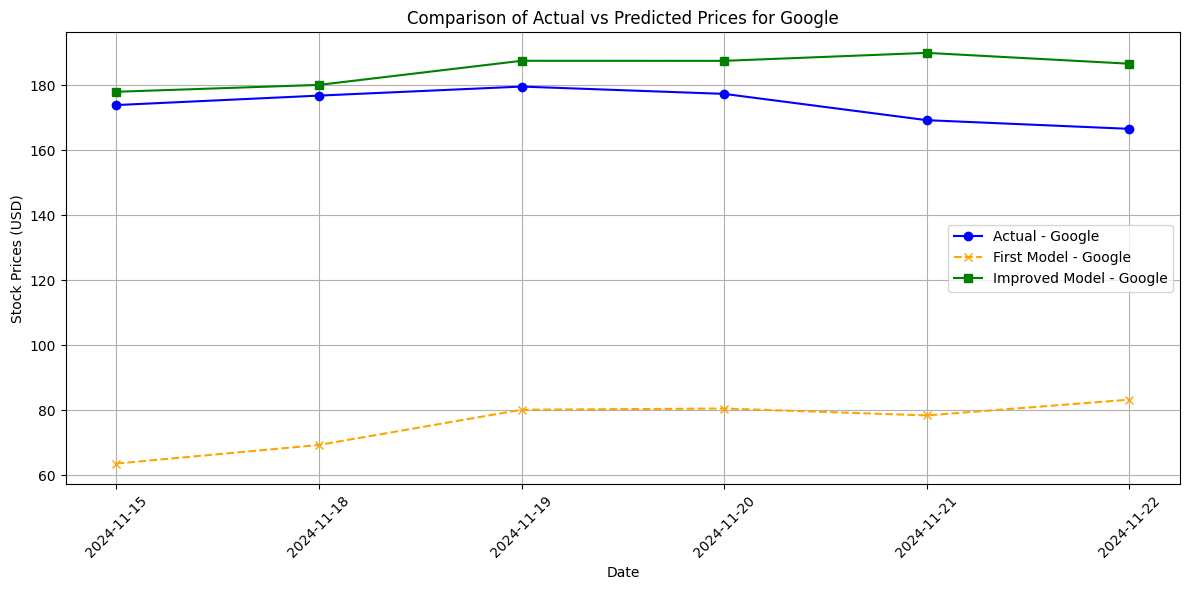

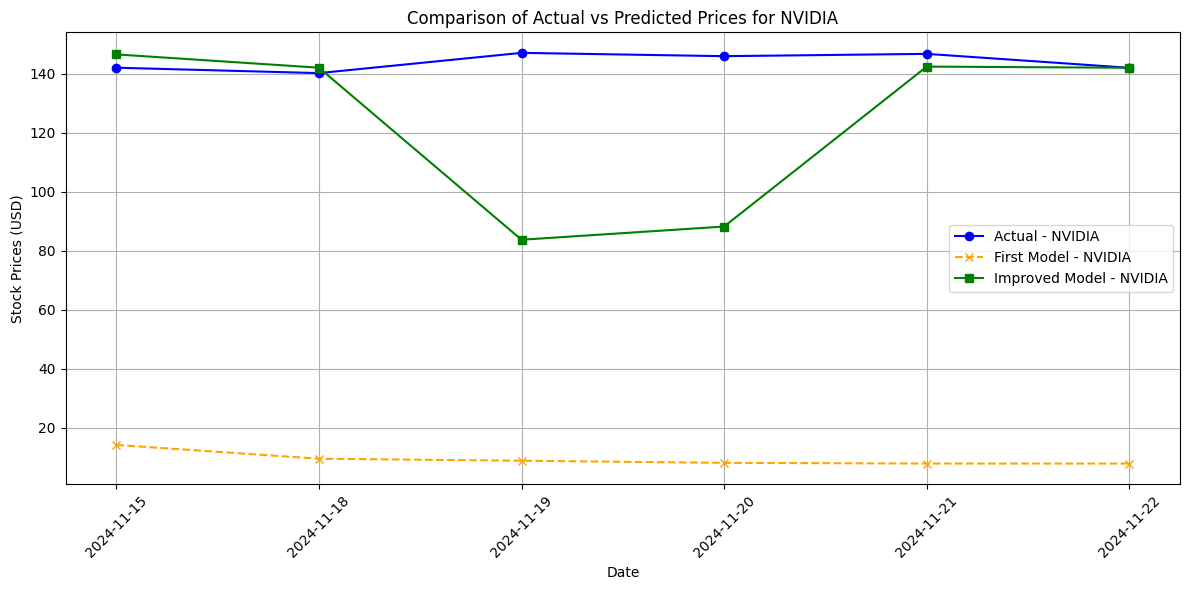

In [ ]:
import matplotlib.pyplot as plt

# Dates for x-axis
forecast_dates = ['2024-11-15', '2024-11-18', '2024-11-19', '2024-11-20',
                  '2024-11-21', '2024-11-22']

# Actual Prices
actual_google = [173.889999, 176.800003, 179.580002, 177.330002, 169.240005, 166.570007]
actual_nvidia = [141.979996, 140.149994, 147.009995, 145.889999, 146.669998, 141.949997]

# First Model Predictions
first_model_google = [63.586933, 69.311440, 80.142845, 80.521629, 78.394279, 83.239494]
first_model_nvidia = [14.149767, 9.467625, 8.790879, 8.069864, 7.834074, 7.834074]

# Improved Model Predictions
accurate_model_google = [177.977417, 180.099075, 187.510437, 187.492462, 189.949387, 186.608688]
accurate_model_nvidia = [146.490799, 141.983047, 83.680367, 88.152962, 142.354706, 141.969147]

# Plotting for Google
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_google, label="Actual - Google", color='blue', marker='o')
plt.plot(forecast_dates, first_model_google, label="First Model - Google", linestyle='--', marker='x', color='orange')
plt.plot(forecast_dates, accurate_model_google, label="Improved Model - Google", linestyle='-', marker='s', color='green')

plt.title("Comparison of Actual vs Predicted Prices for Google")
plt.xlabel("Date")
plt.ylabel("Stock Prices (USD)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting for NVIDIA
plt.figure(figsize=(12, 6))
plt.plot(forecast_dates, actual_nvidia, label="Actual - NVIDIA", color='blue', marker='o')
plt.plot(forecast_dates, first_model_nvidia, label="First Model - NVIDIA", linestyle='--', marker='x', color='orange')
plt.plot(forecast_dates, accurate_model_nvidia, label="Improved Model - NVIDIA", linestyle='-', marker='s', color='green')

plt.title("Comparison of Actual vs Predicted Prices for NVIDIA")
plt.xlabel("Date")
plt.ylabel("Stock Prices (USD)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
